# Data Mining Versuch Clustering von Pokemon

* Autoren: Manuel Eberhardinger, Johannes Theodoridis

* Dozenten: Manuel Eberhardinger, Florian Rupp

* Studierende: Paul Michels (pm080), Erzan Gashi (eg053), Patryk Gadziomski (pg058)

## Abgabe:

- **Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen und den entsprechenden Ausgaben.**
- **Das Notebook ist als .ipynb und als .html abzugeben.**
- **Klausurelevante Fragen sind Dokument "Fragenkatalog Datamining" zu finden.**
- Antworten auf Fragen im Notebook, Diskussionen und Beschreibung der Ergebnisse sind optional (aber empfohlen) und werden nicht bewertet.

* [Übersicht Data Mining Praktikum](https://maucher.pages.mi.hdm-stuttgart.de/ai/page/dm/)


# Einführung

## Lernziele:

In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Kennenlernen der Pokemon API
* Abfrage von Pokemon-Merkmalen über die API (Data Collection)
* Erstellen der Features für Pokemons (Feature Extraction + Data Preprocessing)
* Kennenlernen verschiedener Clustering-Algorithmen 
* Selektion der aussagekräftigsten Merkmale (Feature Selection)
* Clustering von ähnlichen Pokemons


## Vor dem Versuch zu klärende Fragen

### Kennenlernen der Pokemon API

In diesem Versuch wird die [Pokemon API](https://pokeapi.co/docs/v2) eingesetzt, um Features für verschiedene Pokemon über den [API Endpoint](https://pokeapi.co/docs/v2#pokemon) zu bekommen. Die API ist öffentlich verfügbar und man braucht somit keinen Account um Daten abfragen zu können. In diesem Versuch wollen wir keine fertige Library benutzen, die Daten für uns abfragen kann, sondern holen diese Daten mit der [requests](https://requests.readthedocs.io/en/latest/) Python-Bibliothek selber. 

1. Machen Sie sich mit der Pokemon API vertraut, speziell mit dem Pokemon endpoint. Diesen finden Sie über das Menü auf der Webseite: `Contents -> Pokémon -> Pokémon`.
2. Installieren Sie die Python-Bibliothek `requests` mit pip und führen Sie manuell ein paar beispielhafte Abfragen der Pokemon API durch. Benutzen Sie hierzu die `get` methode von requests mit einer endpoint URL. Eine Authentifizierung ist nicht notwendig. Versuchen Sie verschiedene IDs oder Namen aus und geben Sie den Statuscode sowie den Inhalt der response als Text oder JSON aus.

In [303]:
import requests as req
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import numpy as np
import pandas as pd
from requests import HTTPError, Timeout, TooManyRedirects
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

import plotly.express as px
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

In [145]:
# Diese Einstellung erlaubt uns alle Spalten eines pandas Dataframes auszugeben
pd.set_option('display.max_columns', None)

In [146]:
r = req.get("https://pokeapi.co/api/v2/ability/?limit=20&offset=0")
print(r.status_code)
print(r.text)

r = req.get("https://pokeapi.co/api/v2/pokemon-species/?limit=20&offset=0")
print(r.status_code)
print(r.text)

r = req.get("https://pokeapi.co/api/v2/pokemon-species/143/")
print(r.status_code)
print(r.text)


200
{"count":367,"next":"https://pokeapi.co/api/v2/ability/?offset=20&limit=20","previous":null,"results":[{"name":"stench","url":"https://pokeapi.co/api/v2/ability/1/"},{"name":"drizzle","url":"https://pokeapi.co/api/v2/ability/2/"},{"name":"speed-boost","url":"https://pokeapi.co/api/v2/ability/3/"},{"name":"battle-armor","url":"https://pokeapi.co/api/v2/ability/4/"},{"name":"sturdy","url":"https://pokeapi.co/api/v2/ability/5/"},{"name":"damp","url":"https://pokeapi.co/api/v2/ability/6/"},{"name":"limber","url":"https://pokeapi.co/api/v2/ability/7/"},{"name":"sand-veil","url":"https://pokeapi.co/api/v2/ability/8/"},{"name":"static","url":"https://pokeapi.co/api/v2/ability/9/"},{"name":"volt-absorb","url":"https://pokeapi.co/api/v2/ability/10/"},{"name":"water-absorb","url":"https://pokeapi.co/api/v2/ability/11/"},{"name":"oblivious","url":"https://pokeapi.co/api/v2/ability/12/"},{"name":"cloud-nine","url":"https://pokeapi.co/api/v2/ability/13/"},{"name":"compound-eyes","url":"https://

3. Welchen Python Datentyp liefert die Methoden `.json()` einer requests-Response zurück?

In [142]:
# Your Code

print(type(r.json()))

<class 'dict'>


Antwort:
Der Type der response r ist dict. Das gleicht einem Python Dictionary.

4. Schauen Sie sich nochmal das Kapitel zum unüberwachten Lernen der KI-Vorlesung an: [https://lectures.mi.hdm-stuttgart.de/mi7ai/06Clustering.html#introduction](https://lectures.mi.hdm-stuttgart.de/mi7ai/06Clustering.html#introduction) (**user**: *mi7ai*, **pw**: *ailecture*)
5. Beschreibt kurz die Clustering-Verfahren KMeans und DBSCAN. Was sind die jeweiligen Vor- und Nachteile der beiden Verfahren? Worin unterscheiden sie sich?

## KMeans
Beschreibung: 

Bei dem KMeans Clusterung Verfahren werden anfangs zufällige Cluster Mitten ausgewählt.
Die Trainingsdaten werden dem Cluster zugewiesen, wessen Mitte am nächsten ist. Für jedes Cluster wird die Mitte neu ermittelt in dem der Schwerpunkt von allen Trainigsdaten berechnet wird, welche zu einem Cluster zugeteilt wurden. Wenn sich die Mitten der Cluster nicht mehr verschieben ist das Clustering fertig.



Pros:

* Effizient und schnell, insbesondere bei großen Datensätzen.

* Minimiert den Rekonstruktionsfehler, was den Algorithmus ideal für Quantisierungsaufgaben macht.

* In der Regel wird die euklidische Distanz als Maß verwendet, aber es sind auch andere Distanz-Metriken möglich.

Cons:

* Die Anzahl der Cluster muss vom Benutzer vorgegeben werden, was die Auswahl eines geeigneten Wertes von k erfordert.

* Das Ergebnis kann stark von den zufällig gewählten Anfangs-Clustern abhängen, da der Algorithmus in lokalen Minima stecken bleiben kann.

* K-Means ist anfällig für Ausreißer, die das Ergebnis verzerren können, da alle Punkte einem Cluster zugewiesen werden.

* Er eignet sich nur für Cluster, die ungefähr kreisförmig und gleich groß sind. Nicht-lineare oder überlappende Clusterformen kann der Algorithmus schlecht abbilden.


## DBSCAN
Beschreibung:

Der DBSCAN ermöglicht es, Cluster in einem Datensatz zu identifizieren der auf räumlicher Nähe, sondern auch auf Dichte basiert. Anders als bei K-Means benötigt DBSCAN keine im voraus festgelegten Cluster. Somit ist dieser Algorithmus flexibler als andere.
Ein zufällig nicht besuchter Kernpunkt wird ausgewählt und alle erreichbaren Punkte in seiner Nachbarshaft werden identifiziert. Diese Punkt bilden ein Cluster. Dieser Vorgang wird nun wiederholt, indem er neue Kernpunkte findet, die nicht Teil eines Clusters sind, und die Nachbarschaft jedes Kernpunkts durchsucht, bis alle Kernpunkte besucht wurden.


Pros:

* keine Anzahl an Clustern muss vorher festgelegt werden

* Ausreißer werden nicht den Clustern zugewiesen und beeinträchtigen nicht das Ergebnis
Ist auch für größere Datensätze gut angepasst.

* skaliet auch bei großen Datensätzen gut

Cons:

* es kann schwierig sein Ausreißer zu identifizieren und zu behandeln

* es kann schwierig sein vorallem bei großen Datensätzen, geeignete Werte für die Parameter &#949; (maximale Distanz zweier Punkte um als benachbart zugelten) und MinPts (minimal benötigte Anzahl von Punkte dass ein Punkt als Kernpunkt gilt) zu finden

Unterschiede:

Konfigurationparameter: K-means --> Clusteranzahl; DBSCAN --> &#949; ,M mindest Anzahl der nahen Punkte um ein Kernpunkt zu sein

Beachten von Ausreisern: K-means --> ja, ordnet diese auch zu clustern hinzu ; DBSCAN --> nein, ignoriert diese und fügt sie keinem cluster hinzu


# Durchführung
## 1. Data Collection, Feature Extraction & Preprocessing

Als Erstes müssen wir Daten über die API holen, damit wir diese für das Erstellen der Features benutzen können. Wir arbeiten hier nur mit Daten über Pokemons und nicht mit den verschiedenen Fertigkeiten oder Attacken. Diese können für weitere eigene Experimente benutzt werden. Diesmal installieren wir keine spezielle Bibliothek, sondern holen uns die Daten selber über die [requests](https://requests.readthedocs.io/en/latest/) Bibliothek. Damit wollen wir euch zeigen, dass es auch ohne spezielle Frameworks sehr leicht ist, Daten in Python zu crawlen. Die meisten APIs arbeiten heutzutage mit JSON, es gibt aber auch noch Ausnahmen, die z.B. mit XML arbeiten. [JSON-Objekte](https://requests.readthedocs.io/en/latest/user/quickstart/#json-response-content) kann requests ohne Probleme selber parsen, da ein JSON-Objekt einfach in ein Python-Dictionary umgewandelt werden kannn. 

**Aufgaben 1:**
1. Implementiert eine Funktion `call_api(endpoint, resource_id)`, die euch für verschiedene endpoints Daten in einem Dictionary zurückgeben kann. Die endpoint URL muss dabei dynamisch um die id (oder den Namen) erweitert werden.
2. Um HTTP Fehler zu bemerken ruft auf dem Response-Objekt die Methode `raise_for_status()` auf damit wir mögliche Exceptions später korrekt abfangen können.
3. Zum Testen der Methode, holt euch die Daten für Pikachu über den Endpoint `https://pokeapi.co/api/v2/pokemon/{id or name}/`. Pikachu hat die id 25. Was passiert bei id 0? Analysiert die erste Ebene des Dictionaries mit der `.keys()` Methode.

In [3]:
# Your Code
def call_api(endpoint, resource_id):
    url = f"https://pokeapi.co/api/v2/{endpoint}/{resource_id}"
    r = req.get(url)
    
    rsponse_status = r.raise_for_status()
    return(r.json())

In [148]:
pika = call_api("pokemon", 25)
pika

{'abilities': [{'ability': {'name': 'static',
    'url': 'https://pokeapi.co/api/v2/ability/9/'},
   'is_hidden': False,
   'slot': 1},
  {'ability': {'name': 'lightning-rod',
    'url': 'https://pokeapi.co/api/v2/ability/31/'},
   'is_hidden': True,
   'slot': 3}],
 'base_experience': 112,
 'cries': {'latest': 'https://raw.githubusercontent.com/PokeAPI/cries/main/cries/pokemon/latest/25.ogg',
  'legacy': 'https://raw.githubusercontent.com/PokeAPI/cries/main/cries/pokemon/legacy/25.ogg'},
 'forms': [{'name': 'pikachu',
   'url': 'https://pokeapi.co/api/v2/pokemon-form/25/'}],
 'game_indices': [{'game_index': 84,
   'version': {'name': 'red', 'url': 'https://pokeapi.co/api/v2/version/1/'}},
  {'game_index': 84,
   'version': {'name': 'blue', 'url': 'https://pokeapi.co/api/v2/version/2/'}},
  {'game_index': 84,
   'version': {'name': 'yellow',
    'url': 'https://pokeapi.co/api/v2/version/3/'}},
  {'game_index': 25,
   'version': {'name': 'gold', 'url': 'https://pokeapi.co/api/v2/version

In [ ]:
#call_api("pokemon", 0) #results in Error Code 404

Bei ID 0 bekommen wir einen 404 Error, da kein Eintrag mit der ID 0 existiert.

In [149]:
print(call_api("pokemon", 25).keys())

dict_keys(['abilities', 'base_experience', 'cries', 'forms', 'game_indices', 'height', 'held_items', 'id', 'is_default', 'location_area_encounters', 'moves', 'name', 'order', 'past_abilities', 'past_types', 'species', 'sprites', 'stats', 'types', 'weight'])


Durch das Aufrufen der .keys() Funktion, bekommen wir eine Liste an features, welche in der API vorhanden und abrufbar sind.

4. Analysiert die Struktur bzw. die Datentypen der Keys `name, height, weight` sowie `stats` und `types` aus dem Dictionary mit der Beschreibung der API Dokumentation.

In [153]:
# Test Cell

result = call_api(endpoint='pokemon', resource_id=25)

print(f'''{result['id']}: {result['name']}
name:   {type(result["name"])}  # The name for this resource.
height: {type(result["height"])}  # The height of this Pokémon in decimetres.
weight: {type(result["weight"])}  # The weight of this Pokémon in hectograms.
stats:  {type(result['stats'])} # A list of base stat values for this Pokémon.
types:  {type(result['types'])} # A list of details showing types this Pokémon has.
''')

25: pikachu
name:   <class 'str'>  # The name for this resource.
height: <class 'int'>  # The height of this Pokémon in decimetres.
weight: <class 'int'>  # The weight of this Pokémon in hectograms.
stats:  <class 'list'> # A list of base stat values for this Pokémon.
types:  <class 'list'> # A list of details showing types this Pokémon has.



5. Gebt für Pikachu nun **manuell** den Name, Höhe und Gewicht, die Namen und Werte der Stats sowie die Typ(en) aus. Für Stats und Types ist eine geschachtelte Abfrage notwendig. Beachten Sie, dass manche Pokemons mehr als einen Typ haben können.

In [155]:
result = call_api(endpoint='pokemon', resource_id=25)

print(f'''--- PIKACHU ---
name:   {result["name"]}
height: {result["height"]}
weight: {result["weight"]}''')

print('--- Stats: ---')
for i in result['stats']:
    print(i['stat']['name'], ':', i['base_stat'])
    
print('--- Types: ---')
for i in result['types']:
    print('Type', ':', i['type']['name'])


--- PIKACHU ---
name:   pikachu
height: 4
weight: 60
--- Stats: ---
hp : 35
attack : 55
defense : 40
special-attack : 50
special-defense : 50
speed : 90
--- Types: ---
Type : electric


**Aufgabe 2:**

1. Implementiert nun eine Funktion `parse_poke_dict(pokemon)`, die das Dictionary, das von der `call_api`-Funktion zurückgegeben wurde, in ein Dictionary mit ausgewählten Features umwandelt (reduziert). Verwendet dafür die Keys und Features aus der vorherigen Aufgabe.
2. Das neue Dictionary soll nicht mehr verschachtelt sein. Einzelne Stats werden also auf der selben Hierarchieebene wie `name`, `height` und `weight` eingefügt. Verfügbare Types werden als Keys verwendet und auf den Value `1` gesetzt. Das ermöglicht uns später eine einfache Umwandlung der Types in ein binäres Encoding mit Pandas (ähnlich zu One-Hot Encoding, ein Pokemon kann aber mehr als einen Type haben).

In [163]:
# Your Code
def parse_poke_dict(pokemon):
    feature_list = ['name', 'height', 'weight', 'stats', 'types']

    selected_features = {key:pokemon[key] for key in pokemon if key in feature_list}

    stats = selected_features['stats']
    for i in stats:
        selected_features[i['stat']['name']] = i['base_stat']

    types = selected_features['types']
    for j in types:
        selected_features[j['type']['name']] = 1

    selected_features.pop('stats', None)
    selected_features.pop('types', None)

    return selected_features

3. Vergleichen Sie die neue Methode mit der manuellen Abfrage um sicherzustellen, dass alle Features korrekt übernommen wurden.

In [164]:
# Test Cell
pika = parse_poke_dict(call_api('pokemon', 25))
pika

{'height': 4,
 'name': 'pikachu',
 'weight': 60,
 'hp': 35,
 'attack': 55,
 'defense': 40,
 'special-attack': 50,
 'special-defense': 50,
 'speed': 90,
 'electric': 1}

**Aufgabe 3:**

1. Implementiert eine Funktion `get_img(pokemon)` welche ein noch nicht reduziertes Pokemon Dictionary akzeptiert und für dieses Pokemon das entsprechende Sprite (Bild) herunterlädt und zurück gibt. Hierzu ist ein weiterer `get`-Request notwendig.
2. Die Download URLs können über den Key 'sprites' abgfragt werden. Wir möchten die Ansicht 'front_default' herunterladen.
3. Der Inhalt der Response kann mit `.content` abgerufen werden. Um ein RGB-Bild zu erhalten muss dieser zunächst der Methode `BytesIO` und dann der Methode `Image.open` übergeben werden. Hierzu ist die `Pillow`-Bibliothek notwendig. Installiert diese also zunächst über pip und importiert dann das `Image`-Modul mit: `from PIL import Image`. Die `BytesIO`-Methode kann über die Python standard Bibliothek `io` importiert werden. Welchen Datentyp haben die Bilder die von der Methode zurückgegeben werden?

In [166]:
# Your Code
def get_img(pokemon):
    url = pokemon['sprites']['front_default']
    picture = req.get(url)
    return Image.open(BytesIO(picture.content))

4. Für die Ausgabe der Bilder könnt ihr anstatt `print` die `display` Methode verwenden. Jupyter ruft diese implizit immer auf dem letzten Rückgabewert einer Zelle auf, daher werden Bilder angezeigt wenn sie der letzte Rückgabewert der Zelle waren.

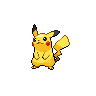

In [168]:
# Test Cell
display(get_img(call_api('pokemon',25)))

**Aufgabe 4:**

Mit den bisher implementierten Methoden können wir nun unseren **Pokedex** erstellen. Dieser könnte zwar als Klasse implementiert werden, wir speichern die Daten und Bilder jedoch der Einfachheit halber separat in einem Pandas Dataframe und einem Numpy Array.

1. Implementiert eine Funktion `catch_them_all(n=151)`, welche für $n$ Pokemon die reduzierten Feature Dictionaries und Bilder sammelt. Wir verwenden $n=151$ als Default da das alle Pokemon aus der ersten Edition sind.
2. Verwendet die Methoden `call_api`, `parse_poke_dict` und `get_img` in einer Schleife um alle Pokemon abzufragen.
3. Die Dictionaries sollen zunächst in einer Python Liste gesammelt, und dann als Pandas Dataframe ausgegeben werden. Als Index soll dabei `name` verwendet werden. Was fällt bei der Betrachtung der kategorialen Einträge auf? Behebt das Problem in dem Ihr einen passenden Wert für fehlende Einträge setzt.
4. Die Bilder sammeln wir separat in einem Numpy Array. Da Numpy etwas picky sein kann wenn Objekte wie PNG Bilder abgespeichert werden sollen, erstellen wir die Listen nicht wie üblich mit `np.array([])` sondern mit `np.empty(shape=(n,), dtype=object)`. Um Objekte hinzuzufügen wird dann nicht wie üblich `np.append` verwendet sondern eine Zuweisung mit Index, also `a[i] = item`.
5. Der Grund warum wir hier ein Numpy array verwenden ist, dass wir später potentielle Cluster sehr einfach über eine Indize-Liste abfragen können, sowohl im Dataframe als auch im Array. Beispiel:

In [170]:
import numpy as np
import pandas as pd

demo_data = pd.DataFrame(['Poke-1', 'Poke-2', 'Poke-3'])
demo_imgs = np.array(    ['IMG-1' , 'IMG-2' , 'IMG-3' ])

cluster_indices = [2,0]

display(demo_data.iloc[cluster_indices])
display(demo_imgs[cluster_indices])

0
2  Poke-3
0  Poke-1

array(['IMG-3', 'IMG-1'], dtype='<U5')

In [175]:
def catch_them_all(n):
    pokemon_list = []
    pokemon_pictures = np.empty(shape=(n,), dtype=object)
    for i in tqdm(range(1,n+1)):
        try :
            pokemon = call_api('pokemon', i)
            picture = get_img(pokemon)
            reduced = parse_poke_dict(pokemon)
            pokemon_list.append(reduced)
            pokemon_pictures[i-1] = picture
        except ConnectionError as ce:
            print(f'Pokmon ID: {i}')
            print(f'{ce}: raise on the event of a network problem')
        except HTTPError as he:
            print(f'Pokmon ID: {i}')
            print(f'{he}: raise in the HTTP request returned an unsuccessful status code')
        except Timeout as te:
            print(f'Pokmon ID: {i}')
            print(f'{te}: raise if a request times out')
        except TooManyRedirects as tmre:
            print(f'Pokmon ID: {i}')
            print(f'{tmre}: raise if the request exceeds the confidgured number of maximum redirections')
 
    print(len(pokemon_list))
    pokemon_df = pd.DataFrame(pokemon_list)
    pokemon_df = pokemon_df.fillna(0.0)
    pokemon_df = pokemon_df.set_index('name')
    
    return pokemon_df, pokemon_pictures

In [185]:
pokemons,pictures = catch_them_all(151)

100%|██████████| 151/151 [01:01<00:00,  2.44it/s]

151


In [183]:
pokemons.head()

height  weight  hp  attack  defense  special-attack  \
name                                                              
bulbasaur        7      69  45      49       49              65   
ivysaur         10     130  60      62       63              80   
venusaur        20    1000  80      82       83             100   
charmander       6      85  39      52       43              60   
charmeleon      11     190  58      64       58              80   

            special-defense  speed  grass  poison  fire  flying  water  bug  \
name                                                                          
bulbasaur                65     45    1.0     1.0   0.0     0.0    0.0  0.0   
ivysaur                  80     60    1.0     1.0   0.0     0.0    0.0  0.0   
venusaur                100     80    1.0     1.0   0.0     0.0    0.0  0.0   
charmander               50     65    0.0     0.0   1.0     0.0    0.0  0.0   
charmeleon               65     80    0.0     0.0   1.0     0.0    0.0  0.0   

            normal  electric  ground  fairy  fighting  psychic  rock  steel  \
name                                                                          
bulbasaur      0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
ivysaur        0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
venusaur       0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
charmander     0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
charmeleon     0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   

            ice  ghost  dragon  
name                            
bulbasaur   0.0    0.0     0.0  
ivysaur     0.0    0.0     0.0  
venusaur    0.0    0.0     0.0  
charmander  0.0    0.0     0.0  
charmeleon  0.0    0.0     0.0

In [184]:
pictures[:10]

array([<PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4E58F7B20>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4E5914730>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4E58F7AF0>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4E58F7D30>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4E5BD4F10>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4DB0C77C0>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4DB0C7550>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4D25CC190>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4D25CC400>,
       <PIL.PngImagePlugin.PngImageFile image mode=P size=96x96 at 0x1B4DB0C7580>],
      dtype=object)

Problem: Bei den Types werden für alle Types, über die ein Pokemon nicht verfügt, ein NaN eingefügt. Daraus folgen Fehler bei der späteren Verarbeitung. Diese NaNs müssen durch 0 ersetzt werden, um ein One-Hot-Encoding Format zu bekommen.

4. Um eine Fortschrittsanzeige während des Downloads zu erhalten, installiert zunächst das Paket `tqdm`, importiert es dann wie folgt: `from tqdm.notebook import tqdm` und verwendet es in eurer Schleife, z.B. mit: `for i in tqdm(range(0, n)):`. Evtl. müssen noch die `ipywidgets` installiert werden.
5. Welche **Errors and Exceptions** können bei der Verwendung der [requests](https://requests.readthedocs.io/en/latest/user/quickstart/#errors-and-exceptions) Bibliothek auftreten? Listet diese in einer separaten Markdownzelle auf mit einer kurzen Erklärung der Fehler.

## Errors and Exceptions

* Connection Error, falls ein Netzwerkfehler auftritt.

* HTTPError falls die Response.raise_for_status() Methode einen unerfolgreichen Status code zurück sendet.

* Timeout Exception im Falle eines Timeout bei einer Anfrage.

* TooManyRedirects Exception, wenn bei einer Anfrage eine vorgegebene Anzahl an Weiterleitungen überstritten wird.


6. Wie kann sichergestellt werden, dass die Schleife bei einem Fehler nicht abbricht? Implementiert eine geeignete Lösung damit die Schleife auch mit requests-Exceptions weiterläuft. Informiert die Benutzer*innen der Methode bei welcher ID ein Fehler aufgetreten ist und gebt zusätzlich die Exception bzw. die Info, die der Error liefert. Tipp zum Testen: In Python können Exceptions manuell getriggert werden, z.B. mit `raise KeyError('Hallo, das ist ein KeyError')`, spezifische Exceptions einer Bibliothek müssen davor allerdings importiert werden. Deaktiviert alle manuell ausgelösten Test-Exceptions wieder soblad ihr euch sicher seid, dass diese robust abgefangen werden.
7. Testet euren *Pokedex* in dem ihr die Indizelisten `[0,1,2]` und `[24,150]` ausgeben lasst und stellt sicher, dass die Zuordnung zwischen Dataframe und Bild Array passt. Die `display`-Methode eignet sich hier wieder für die Ausgabe.

height  weight  hp  attack  defense  special-attack  \
name                                                             
bulbasaur       7      69  45      49       49              65   
ivysaur        10     130  60      62       63              80   
venusaur       20    1000  80      82       83             100   

           special-defense  speed  grass  poison  fire  flying  water  bug  \
name                                                                         
bulbasaur               65     45    1.0     1.0   0.0     0.0    0.0  0.0   
ivysaur                 80     60    1.0     1.0   0.0     0.0    0.0  0.0   
venusaur               100     80    1.0     1.0   0.0     0.0    0.0  0.0   

           normal  electric  ground  fairy  fighting  psychic  rock  steel  \
name                                                                         
bulbasaur     0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
ivysaur       0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
venusaur      0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   

           ice  ghost  dragon  
name                           
bulbasaur  0.0    0.0     0.0  
ivysaur    0.0    0.0     0.0  
venusaur   0.0    0.0     0.0

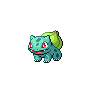

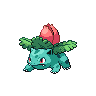

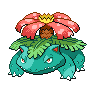

height  weight   hp  attack  defense  special-attack  \
name                                                            
pikachu       4      60   35      55       40              50   
mew           4      40  100     100      100             100   

         special-defense  speed  grass  poison  fire  flying  water  bug  \
name                                                                       
pikachu               50     90    0.0     0.0   0.0     0.0    0.0  0.0   
mew                  100    100    0.0     0.0   0.0     0.0    0.0  0.0   

         normal  electric  ground  fairy  fighting  psychic  rock  steel  ice  \
name                                                                            
pikachu     0.0       1.0     0.0    0.0       0.0      0.0   0.0    0.0  0.0   
mew         0.0       0.0     0.0    0.0       0.0      1.0   0.0    0.0  0.0   

         ghost  dragon  
name                    
pikachu    0.0     0.0  
mew        0.0     0.0

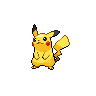

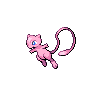

In [186]:
display(pokemons.iloc[[0,1,2]], pictures[0], pictures[1], pictures[2])

display(pokemons.iloc[[24,150]],pictures[24],pictures[150])

Nachdem wir nun unser Dataset gesammelt haben sollten wir als Teil des Preprocessing noch sicherstellen, dass folgende Eigenschaften erfüllt sind: 

1. Keine Null- oder NaN-Werte im DataFrame.
2. Binäres Encoding der kategorischen Werte.
3. Skalieren der Werte mit einem MinMaxScaler.

Zwei davon haben wir schon als Teil der Feature Extraction erledigt. Um die Skalierung kümmern wir uns jetzt.

**Aufgabe 5:**

1. Instanziiert ein `from sklearn.preprocessing import MinMaxScaler` Objekt und wendet diesen auf den Dataframe an.

In [341]:
max_scaler = MinMaxScaler()
data = pokemons
max_scaler.fit(data)
scaled_data = max_scaler.transform(data)

2. Die transformierten Daten sollen wieder in ein Pandas Dataframe umgewandelt werden. Die Columns sowie der Index sind dabei die Selben wie im unskalierten Dataframe.

In [190]:
scaled_df_pokemon = pd.DataFrame(scaled_data, index = data.index, columns = data.columns)

3. Gebt die originalen und skalierten Daten aus, um die Dataframes zu vergleichen.

In [191]:
display(scaled_df_pokemon, pokemons)

height    weight        hp    attack   defense  special-attack  \
name                                                                           
bulbasaur   0.058140  0.014786  0.145833  0.341085  0.251429        0.359712   
ivysaur     0.093023  0.028050  0.208333  0.441860  0.331429        0.467626   
venusaur    0.209302  0.217221  0.291667  0.596899  0.445714        0.611511   
charmander  0.046512  0.018265  0.120833  0.364341  0.217143        0.323741   
charmeleon  0.104651  0.041096  0.200000  0.457364  0.302857        0.467626   
...              ...       ...       ...       ...       ...             ...   
dratini     0.186047  0.006958  0.129167  0.457364  0.228571        0.251799   
dragonair   0.441860  0.035660  0.212500  0.612403  0.342857        0.395683   
dragonite   0.232558  0.456404  0.337500  1.000000  0.514286        0.611511   
mewtwo      0.209302  0.265058  0.400000  0.813953  0.485714        1.000000   
mew         0.023256  0.008480  0.375000  0.736434  0.542857        0.611511   

            special-defense     speed  grass  poison  fire  flying  water  \
name                                                                        
bulbasaur          0.428571  0.222222    1.0     1.0   0.0     0.0    0.0   
ivysaur            0.571429  0.333333    1.0     1.0   0.0     0.0    0.0   
venusaur           0.761905  0.481481    1.0     1.0   0.0     0.0    0.0   
charmander         0.285714  0.370370    0.0     0.0   1.0     0.0    0.0   
charmeleon         0.428571  0.481481    0.0     0.0   1.0     0.0    0.0   
...                     ...       ...    ...     ...   ...     ...    ...   
dratini            0.285714  0.259259    0.0     0.0   0.0     0.0    0.0   
dragonair          0.476190  0.407407    0.0     0.0   0.0     0.0    0.0   
dragonite          0.761905  0.481481    0.0     0.0   0.0     1.0    0.0   
mewtwo             0.666667  0.851852    0.0     0.0   0.0     0.0    0.0   
mew                0.761905  0.629630    0.0     0.0   0.0     0.0    0.0   

            bug  normal  electric  ground  fairy  fighting  psychic  rock  \
name                                                                        
bulbasaur   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
ivysaur     0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
venusaur    0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
charmander  0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
charmeleon  0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
...         ...     ...       ...     ...    ...       ...      ...   ...   
dratini     0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
dragonair   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
dragonite   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
mewtwo      0.0     0.0       0.0     0.0    0.0       0.0      1.0   0.0   
mew         0.0     0.0       0.0     0.0    0.0       0.0      1.0   0.0   

            steel  ice  ghost  dragon  
name                                   
bulbasaur     0.0  0.0    0.0     0.0  
ivysaur       0.0  0.0    0.0     0.0  
venusaur      0.0  0.0    0.0     0.0  
charmander    0.0  0.0    0.0     0.0  
charmeleon    0.0  0.0    0.0     0.0  
...           ...  ...    ...     ...  
dratini       0.0  0.0    0.0     1.0  
dragonair     0.0  0.0    0.0     1.0  
dragonite     0.0  0.0    0.0     1.0  
mewtwo        0.0  0.0    0.0     0.0  
mew           0.0  0.0    0.0     0.0  

[151 rows x 25 columns]

height  weight   hp  attack  defense  special-attack  \
name                                                               
bulbasaur        7      69   45      49       49              65   
ivysaur         10     130   60      62       63              80   
venusaur        20    1000   80      82       83             100   
charmander       6      85   39      52       43              60   
charmeleon      11     190   58      64       58              80   
...            ...     ...  ...     ...      ...             ...   
dratini         18      33   41      64       45              50   
dragonair       40     165   61      84       65              70   
dragonite       22    2100   91     134       95             100   
mewtwo          20    1220  106     110       90             154   
mew              4      40  100     100      100             100   

            special-defense  speed  grass  poison  fire  flying  water  bug  \
name                                                                          
bulbasaur                65     45    1.0     1.0   0.0     0.0    0.0  0.0   
ivysaur                  80     60    1.0     1.0   0.0     0.0    0.0  0.0   
venusaur                100     80    1.0     1.0   0.0     0.0    0.0  0.0   
charmander               50     65    0.0     0.0   1.0     0.0    0.0  0.0   
charmeleon               65     80    0.0     0.0   1.0     0.0    0.0  0.0   
...                     ...    ...    ...     ...   ...     ...    ...  ...   
dratini                  50     50    0.0     0.0   0.0     0.0    0.0  0.0   
dragonair                70     70    0.0     0.0   0.0     0.0    0.0  0.0   
dragonite               100     80    0.0     0.0   0.0     1.0    0.0  0.0   
mewtwo                   90    130    0.0     0.0   0.0     0.0    0.0  0.0   
mew                     100    100    0.0     0.0   0.0     0.0    0.0  0.0   

            normal  electric  ground  fairy  fighting  psychic  rock  steel  \
name                                                                          
bulbasaur      0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
ivysaur        0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
venusaur       0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
charmander     0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
charmeleon     0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
...            ...       ...     ...    ...       ...      ...   ...    ...   
dratini        0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
dragonair      0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
dragonite      0.0       0.0     0.0    0.0       0.0      0.0   0.0    0.0   
mewtwo         0.0       0.0     0.0    0.0       0.0      1.0   0.0    0.0   
mew            0.0       0.0     0.0    0.0       0.0      1.0   0.0    0.0   

            ice  ghost  dragon  
name                            
bulbasaur   0.0    0.0     0.0  
ivysaur     0.0    0.0     0.0  
venusaur    0.0    0.0     0.0  
charmander  0.0    0.0     0.0  
charmeleon  0.0    0.0     0.0  
...         ...    ...     ...  
dratini     0.0    0.0     1.0  
dragonair   0.0    0.0     1.0  
dragonite   0.0    0.0     1.0  
mewtwo      0.0    0.0     0.0  
mew         0.0    0.0     0.0  

[151 rows x 25 columns]

4. Importiert abschliesend die Bibliothek `seaborn` mit `import seaborn as sns` und analysiert die **skalierten numerischen Daten** mit einem [`sns.pairplot` (link)](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Wählt dazu nur die numerischen Columns des Dataframes aus.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



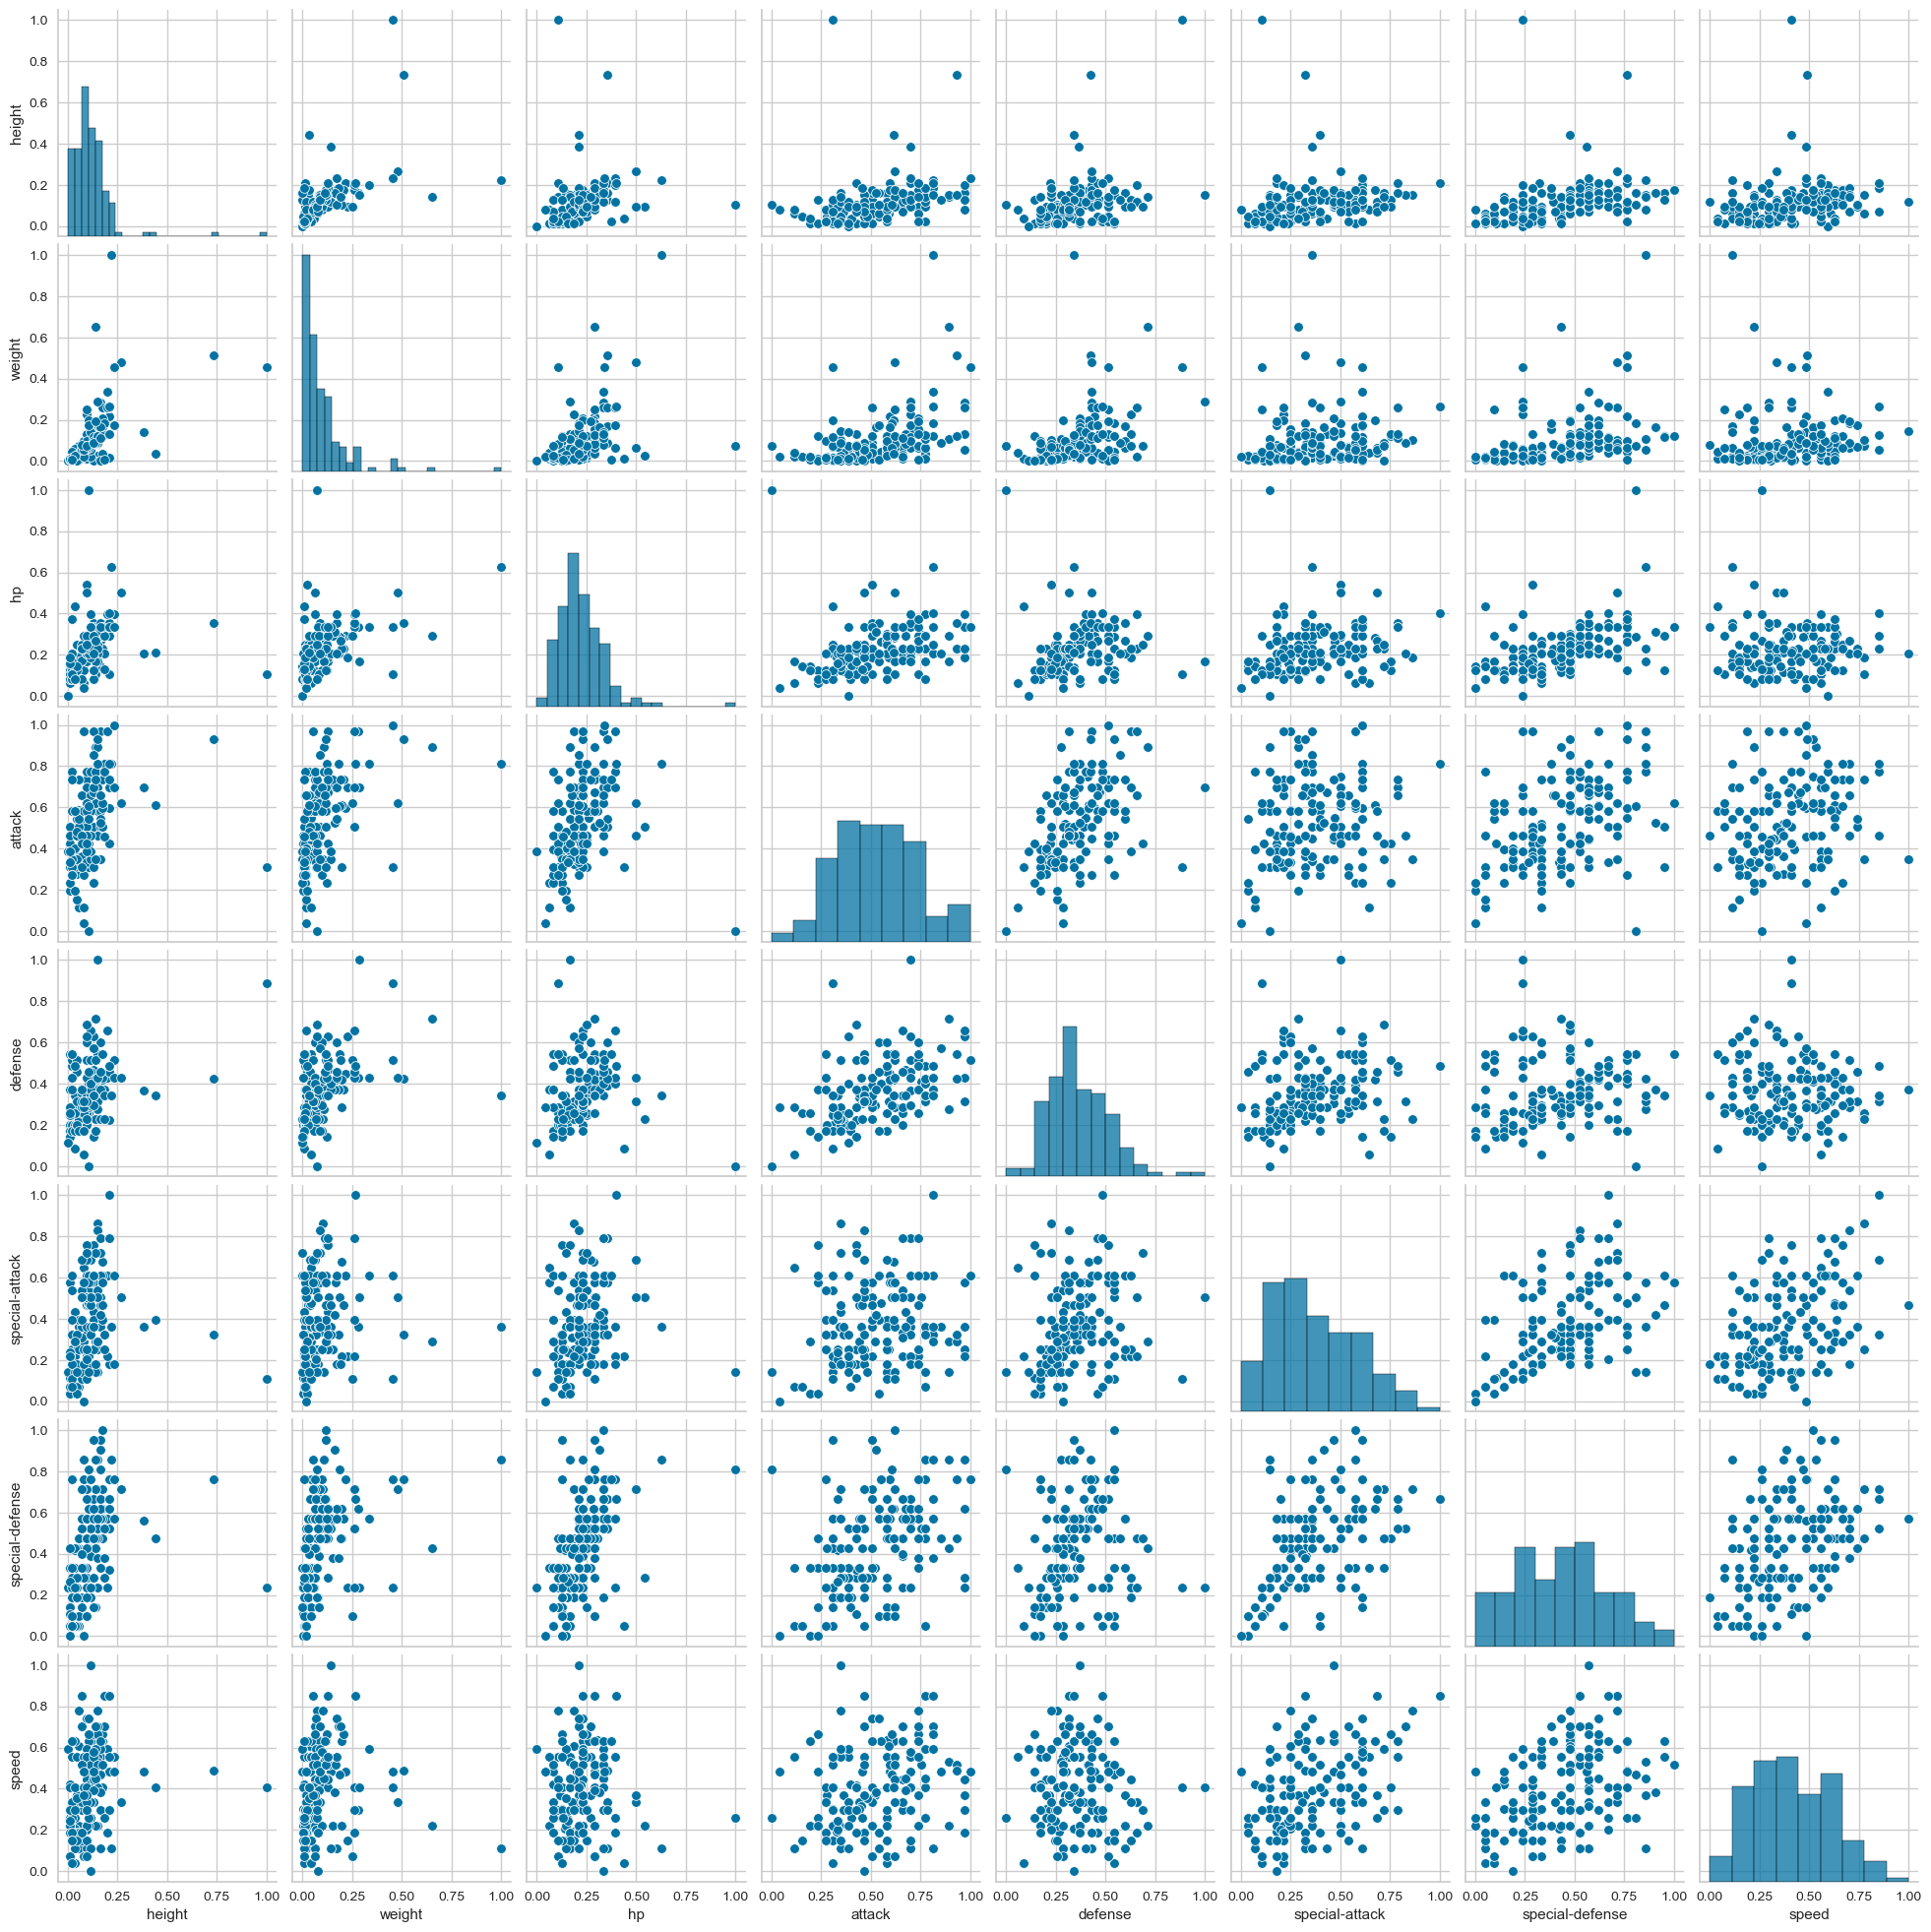

In [193]:
# Test Cell
sns.pairplot(scaled_df_pokemon.iloc[:,0:8])

5. Beschreibt kurz Auffälligkeiten in den Verteilungen (falls vorhanden). 

* Die Kampf-irrelevanten Eigenschaftens sind jeweils links verteilt (height, weight). Eine Außnahme hat der Stat hp. (Wahrscheinlich damit die Kämpfe nicht zu lange gehen)
* Die Kampf-relevanten Eigenschaften sind alle mitting verteilt, bis auf ein paar Ausreißer (sehr schwache Pokemon vs. Legendary Pokemon)
* weight und height korrelieren sehr stark --> kleine Pokemon sind meist auch leicht, große sind schwer (logisch)
* Die meisten Pokemon finden sich auf der linken Seite der Verteilung: Die meisten Pokemon sind klein (so gut wie alle größeren Pokemons habe eine/zwei kleinere Vorentwicklungen, aber nicht jedes kleine Pokemon hat eine große Weiterentwicklung)
* Die Kampf-relevanten Eigenschaften sind in Bezug auf andere sehr weit verteilt im ganzen Scatterplot
* Es gibt nur sehr wenige Pokemon mit besonders hohen Werten in allen Kampf-relevanten Bereichen (Mewto & Mew?)

## 2. Data Visualization & Dimensionsreduktion

Konntet ihr bereits Cluster in den Daten ausfindig machen? Nein? Keine Sorge, wir auch nicht. 

In diesem Abschnitt verwenden wir daher die Principal Component Analysis (PCA) Methode um unsere hochdimensionalen Daten in einem 2D-Raum abzubilden. Diese Methode wird in einer späteren Übung noch genauer erklärt und benutzt. Hier soll sie einfach als Blackbox verwendet werden. Man sollte nur wissen, dass damit ein hochdimensionaler Raum auf wenige Dimensionen reduziert werden kann ohne dabei viel Information zu verlieren. Auch das Clustering werden wir in diesem reduzierten Raum durchführen. Bevor wir uns aber um die PCA kümmern implementieren wir noch ein paar hilfreiche Visualisierungsfunktionen mit denen wir später die gefundenen Cluster besser analysieren können.

**Aufgabe 6:**

1. Implementiert eine Funktion `plot_images(img_list)` die als Input ein Numpy Array mit Pillow Image Objekten akzeptiert und diese in einem fixen Grid visualisiert. Verwendet dazu die Bibliothek `matplotlib` mit `import matplotlib.pyplot as plt`.
2. Erstellt zunächst **eine** neue Figure mit einer geeigneten quadratischen figsize. Pillow Images können mit der Funktion `imshow` geplottet werden. Um die Plots in einm Grid anzuordnen kann die Funktion `add_subplot(nrows, ncols, index)` verwendet werden (index muss bei 1 starten), bei 151 Pokemon ist ein 13x13 Grid eine gute Wahl. Für jeden Subplot können die Achsen mit `plt.axis('off')` deaktiviert werden.
3. Um eine Liste zu iterieren und dabei auch den aktuellen Index zu erhalten kann die Funktion `enumerate(['a','b','c'])` verwendet werden (Achtung: Index startet bei 0).
4. **Nachdem** alle Subplots erstellt wurden, muss **einmal** `plt.show()` aufgerufen werden.

In [284]:
def plot_images(img_list):
    x= math.ceil(math.sqrt(len(img_list)))
    fig = plt.figure(figsize =(x,x))
    img_list_enu = enumerate(img_list)
    for index, value in img_list_enu:
        fig.add_subplot(x,x, index+1)
        plt.axis('off')
        plt.imshow(value)
    plt.show()

5. Testet die Funktion mit dem Indize Subset `[0,1,2,24]` und einmal mit allen Pokemon.

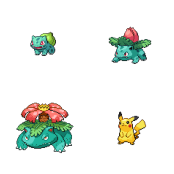

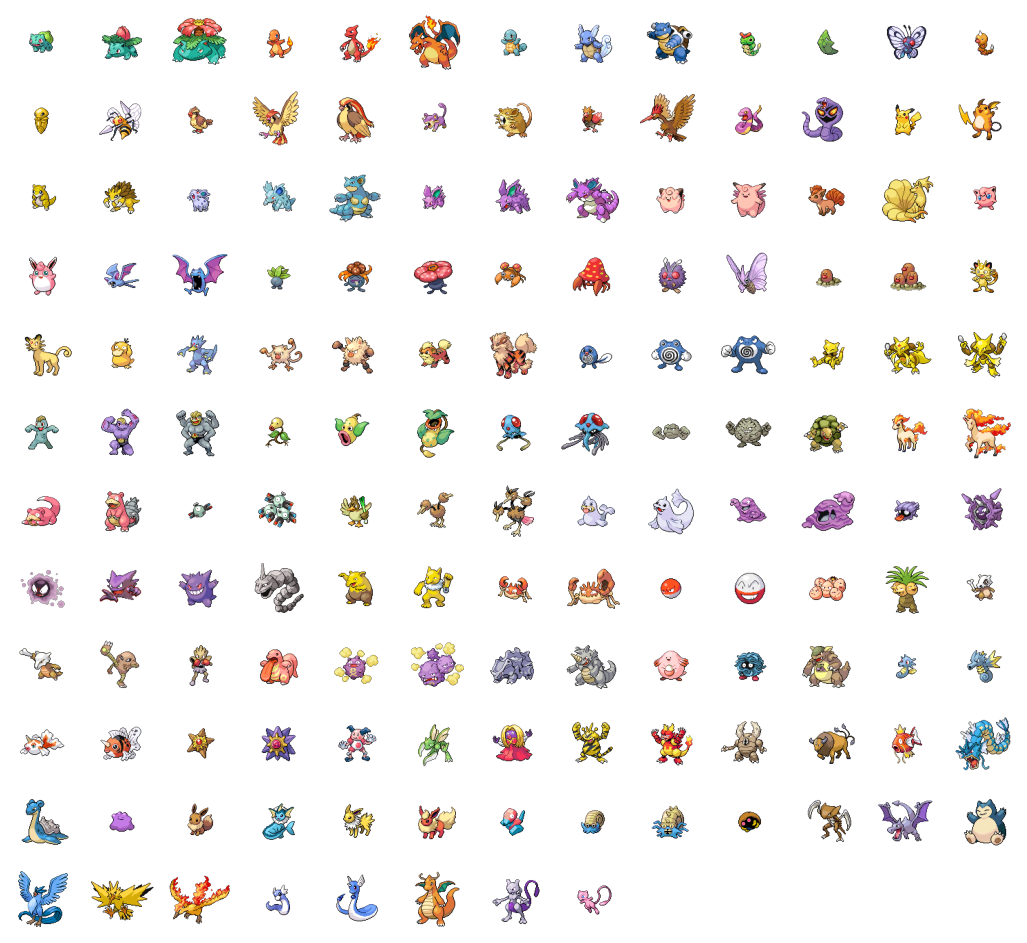

In [267]:
# Test Cell
plot_images(pictures[[0,1,2,24]])
plot_images(pictures)

**Aufgabe 7:**
    
1. Implementiert zwei Funktionen `plot_numerics(dataframe)` und `plot_categories(dataframe)` die als Input ein komplettes Dataframe akzeptieren aber jeweils nur die numerischen oder kategorischen Spalten visualisieren. Verwendet dazu wieder die Bibliothek `seaborn`.
2. Die Methoden sollen selbständig nur die numerischen oder kategorischen Spalten des Dataframes auswählen.
3. Für numerische Werte könnt ihr entweder ein [`sns.barplot` (link)](https://seaborn.pydata.org/generated/seaborn.barplot.html) oder [`sns.boxplot` (link)](https://seaborn.pydata.org/generated/seaborn.boxplot.html) verwenden. Damit wir später verschiedene Cluster miteinander vergleichen können ist eine konstante Y-Range sinnvoll, z.B. `plt.ylim(0,1.1)`.
4. Für kategorische Werte verwendet ihr ein `sns.barplot`. Per Default wendet seaborn hier den `estimator='mean'` auf die Daten an. Ist das für die kategorischen Columns eine geeignete Statistik? Mit welcher einfachen arithmetischen Funktion könnt ihr die Anzahl der binär codierten Kategorien zählen? Verwendet diese als estimator und wählt eine passende konstante Y-Range. Falls Fehlerbalken keine Sinn machen, können diese mit `errorbar=None` deaktiviert werden.
5. Die Labels der X-Achse können mit `plt.xticks(rotation=90)` rotiert werden.
6. Ruft in den Funktionen **noch nicht** `plt.show()` auf damit wir diese in einer Grid Darstellung verwenden können.

In [299]:
def plot_numerics(dataframe):
    data = dataframe.iloc[:,:8]
    plt.ylim(-0.1,1.1)
    sns.boxplot(data)

def plot_categories(dataframe):
    data = dataframe.iloc[:,8:]
    plt.ylim(0,35.0) # wir haben uns für 35 entschieden da später einige Typen einen max count von 30 haben
    sns.barplot(data, estimator='sum', errorbar=None)

7. Testet eure Funktionen mit dem skalierten Dataframe.

Numeric Values Boxplot


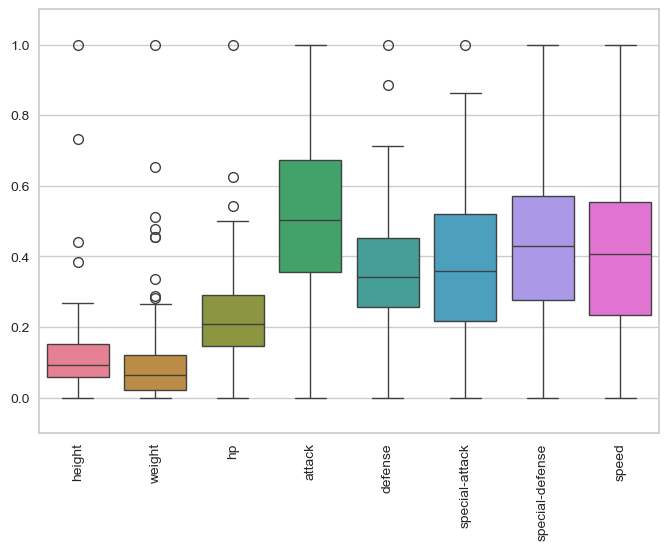

Categoric Values Barplot


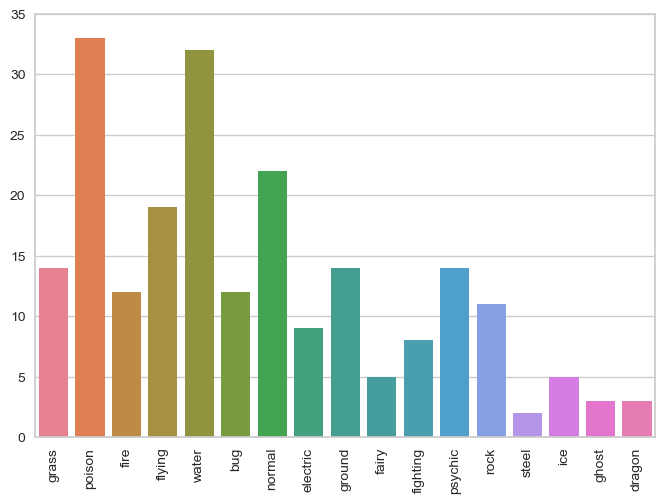

In [288]:
plot_numerics(scaled_df_pokemon)
print('Numeric Values Boxplot')
plt.xticks(rotation=90)
plt.show()

plot_categories(scaled_df_pokemon)
print("Categoric Values Barplot")
plt.xticks(rotation=90)

plt.show()

Die drei bisher implementierten Funktionen möchten wir nun dazu verwenden, um gefundene Cluster zu visualiseren. Mit der untenstehenden Funktion könnt Ihr euch zum Test Fake Cluster generieren. Später implementieren wir diese Datenstruktur mit den echten Clustern. Die Keys des Dictionaries sind die Cluster Namen, die Values jeweils eine Liste mit den Indizes der Pokemon, die zu diesem Cluster gehören.

In [289]:
def get_fake_cluster(n_cluster=5, items_per_cluster=10, n_pokemon=151):

    cluster_dict = {}
    fake_cluster = np.random.choice(n_pokemon, (n_cluster, items_per_cluster), replace=False)
    for i, c in enumerate(fake_cluster):
        cluster_dict[i] = c
    return cluster_dict

test_cluster = get_fake_cluster()
test_cluster

{0: array([141,  48, 140,  84, 108,  65,  24, 130, 114, 109]),
 1: array([ 32, 128, 126,   4,  66,  76, 105, 100,  37,  69]),
 2: array([ 79, 110,  83,   6,   8,  50,  61,  56,  44, 123]),
 3: array([ 28, 138, 137, 125,  55,  81,  45, 101,  23,  86]),
 4: array([103,  91,  96,  92,  17, 150,  12,  26,  71,  57])}

**Aufgabe 8:**

1. Implementiert eine Funktion `compare_cluster(cluster_dict, dataframe, image_array)`, welche als Parameter ein Cluster Dictionary, die Pokemon Daten und Pokemon Bilder akzeptiert und für jedes Cluster die Daten und Bilder visualisiert. Wir vergleichen dabei zunächst die numerischen Werte der Cluster, dann die kategorischen und zum Schluss die Bilder. Geht bei der folgenden Implementierung Schritt für Schritt vor!
2. Erstellt zunächst eine Figure für die numerischen Werte mit der Größe `(20,40)`.
3. Nun iterieren wir über das `cluster_dict`. Da die Cluster Namen nicht zwingend bei 0 starten, ist es gut über den Inhalt des Dictionaries mit `for i, (c_name, c_indices) in enumerate(cluster_dict.items())` zu iterieren.
4. Erstellt für jedes Cluster ein Subplot in einem 10x5 Grid. Damit könnten bis zu 50 Cluster visualisiert werden. Dies ist erstmal ausreichend. Meistens haben wir viel weniger Cluster, die wir vergleichen möchten.
5. Gebt jedem Subplot einen Titel, der den Cluster Namen anzeigt.
6. Benutzt die Cluster Indizes nun um ein Subset des Dataframes zu selektieren und plottet das Cluster mit der `plot_numerics` Funktion.
7. Nach der Schleife ruft ihr `fig.tight_layout(h_pad=1, w_pad=1)` und `plt.show()` auf. Die Layout Funktion könnt ihr in Kombination mit der Größe der Figure verwenden, um die Darstellung schöner zu machen (sollte aber schon passen).
8. Wiederholt die Schritte 2-7, aber ruft dieses mal die Funktion `plot_categories` auf.
9. Iteriert ein letztes mal über das Cluster Dictionary, selektiert nun aber die Bilder und verwendet `plot_images`. Gebt mit einem einfachen `print`-Befehl davor an, welches Cluster gerade angezeigt wird.
10. Testet die Methode mit 1,5 und 10 Clustern. Wird alles korrekt dargestellt? Achtung, es gibt hier nichts inhaltliches zu analysieren. Das sind bisher nur Test Cluster ;) Zeigt bei der Abgabe, dass es für 10 Cluster gut funktioniert.

In [290]:
def compare_cluster(cluster_dict, dataframe, image_array):
        
    fig = plt.figure(figsize = (20,40))
    cluster_count = len(cluster_dict)
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        fig.add_subplot(10,cluster_count,i+1,title=c_name)
        plot_numeric(dataframe.loc[dataframe.index[c_indices]])
        plt.xticks(rotation=90)
        
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        fig.add_subplot(10,cluster_count,i+1+cluster_count,title=c_name)
        plot_categories(dataframe.loc[dataframe.index[c_indices]])
        plt.xticks(rotation=90)
    
        
    fig.tight_layout(h_pad=1, w_pad=1)
    plt.show()
    
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        print(f'Cluster: {c_name}')
        fig.add_subplot(10,cluster_count,i+1+(2*cluster_count),title=c_name)
        plot_images(image_array[c_indices])

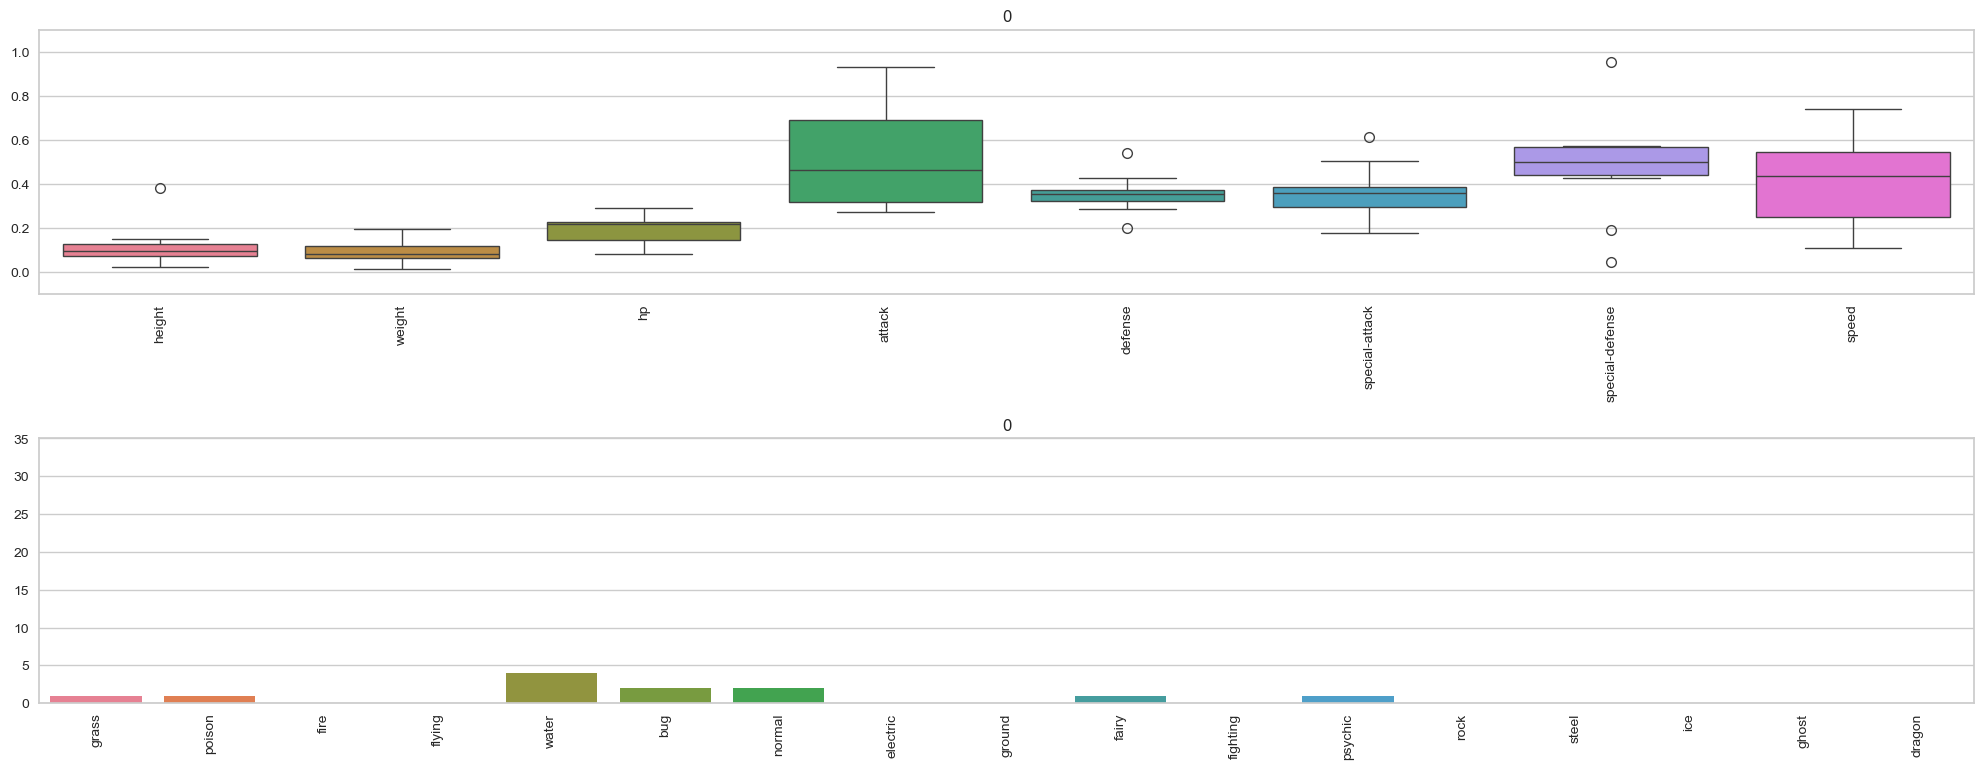

Cluster: 0


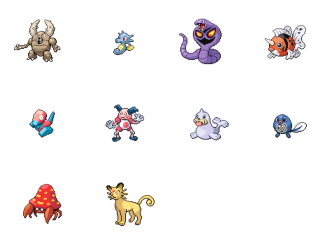

In [294]:
test_cluster_1 = get_fake_cluster(1,10,151)
test_cluster_5 = get_fake_cluster(5,10,151)
test_cluster_10 = get_fake_cluster(10,10,151)

compare_cluster(test_cluster_1,scaled_df_pokemon,pictures)

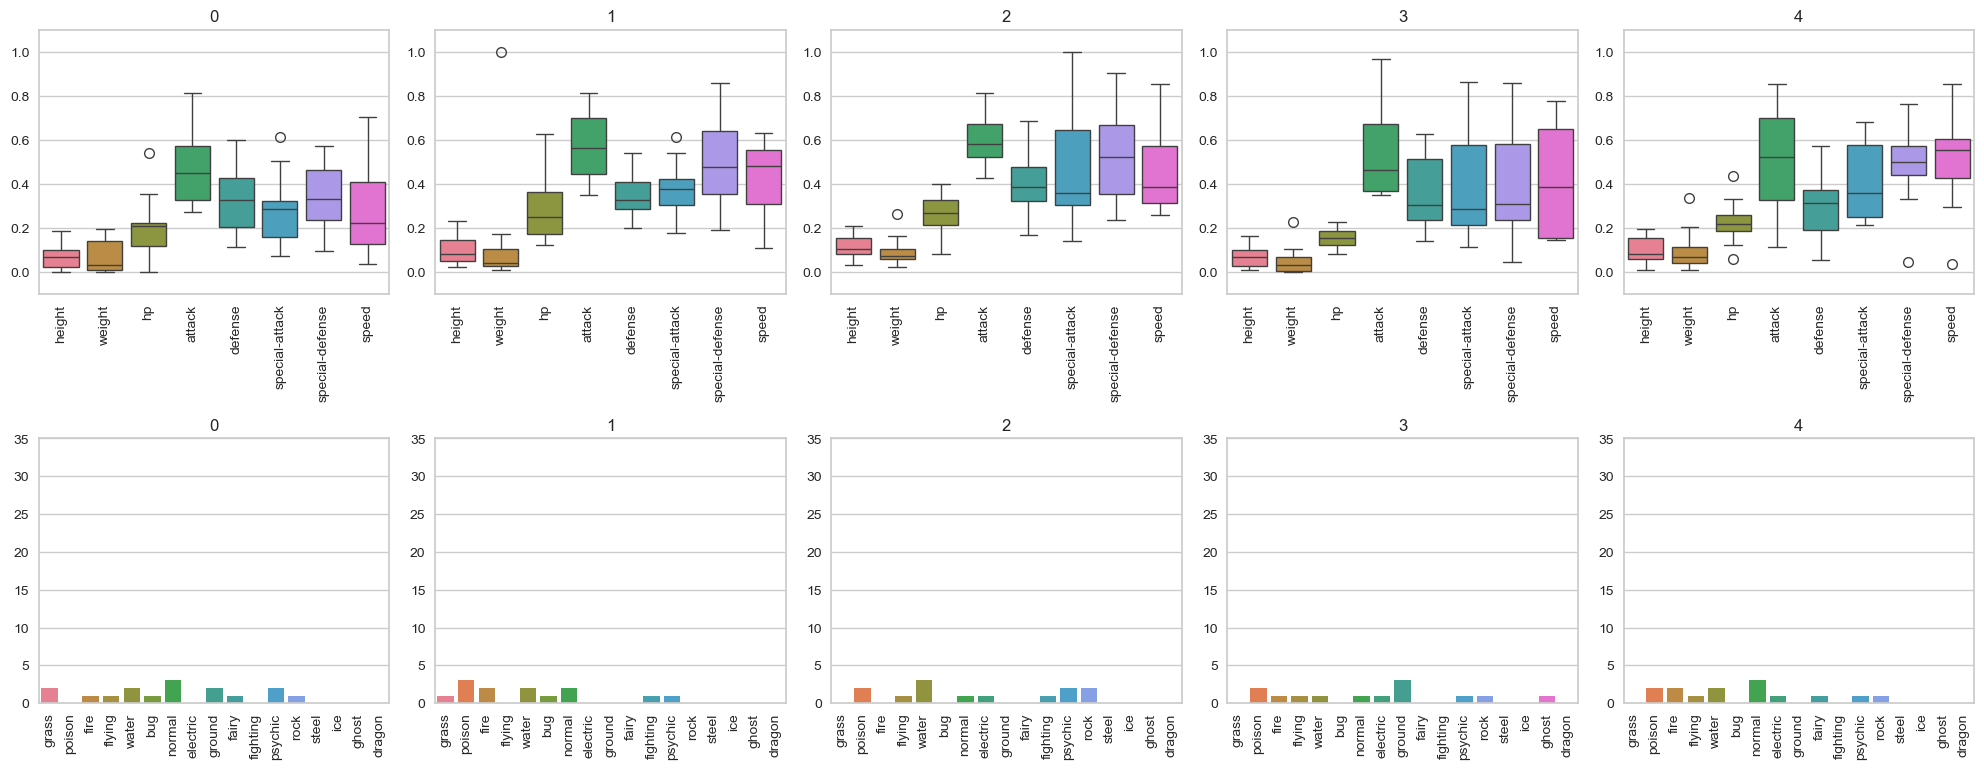

Cluster: 0


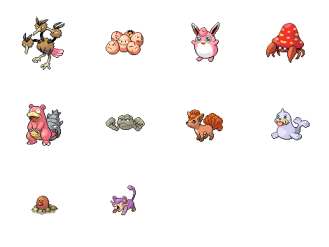

Cluster: 1


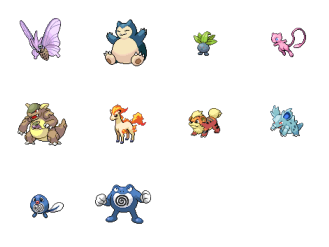

Cluster: 2


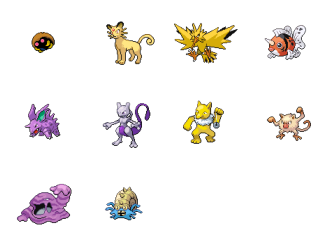

Cluster: 3


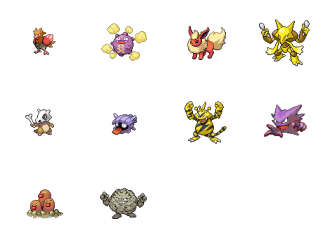

Cluster: 4


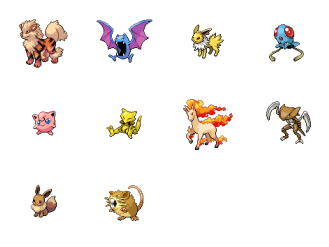

In [295]:
# Test Cell
compare_cluster(test_cluster_5,scaled_df_pokemon,pictures)

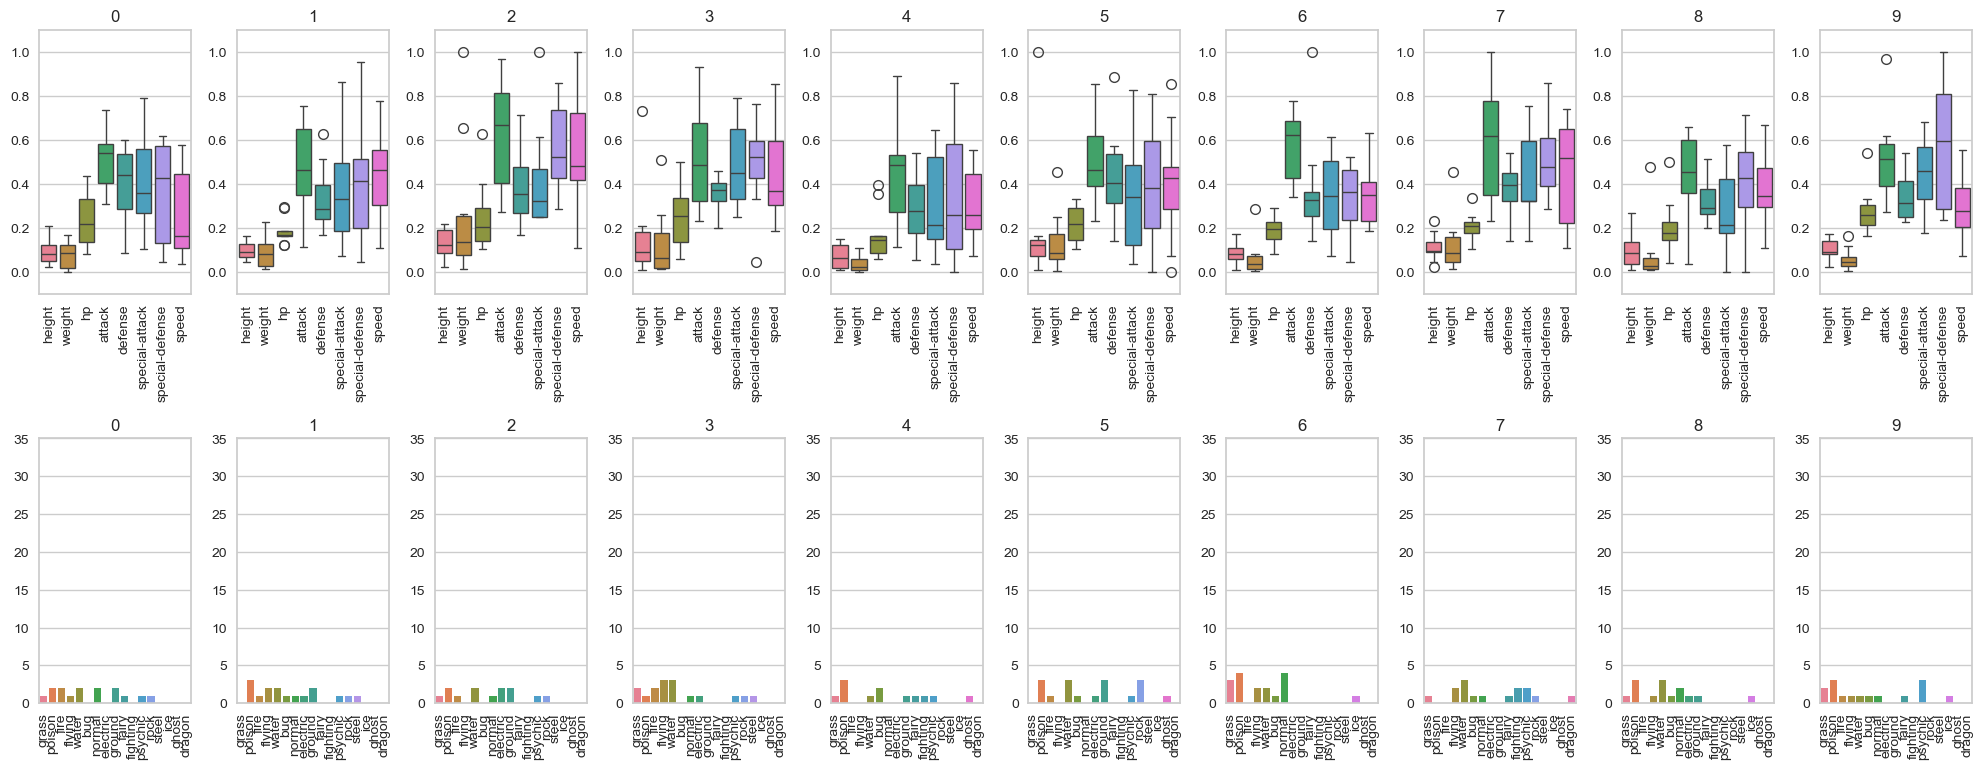

Cluster: 0


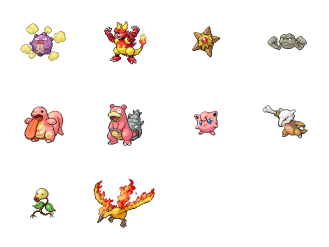

Cluster: 1


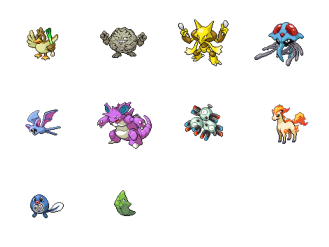

Cluster: 2


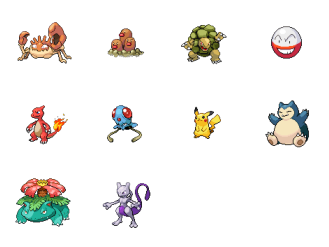

Cluster: 3


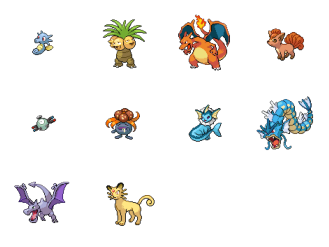

Cluster: 4


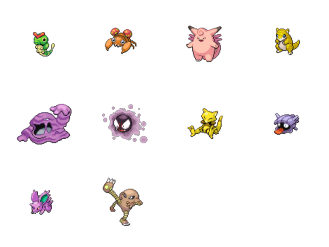

Cluster: 5


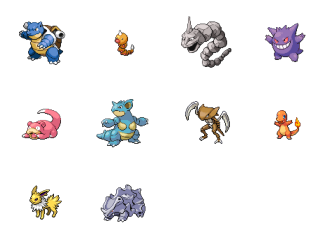

Cluster: 6


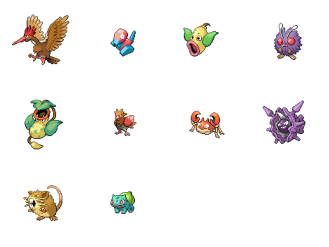

Cluster: 7


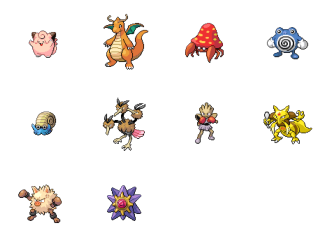

Cluster: 8


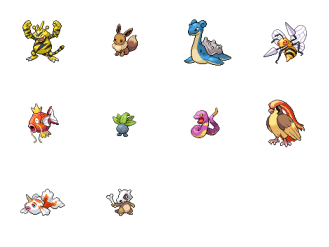

Cluster: 9


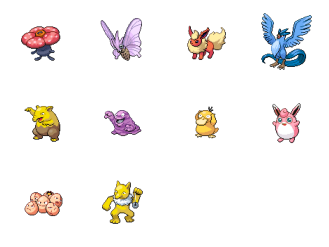

In [296]:
compare_cluster(test_cluster_10,scaled_df_pokemon,pictures)

Bisher können wir potentielle Cluster im hochdimensionalen Raum vergleichen, was uns erlaubt die Eigenschaften der gefundenen Cluster zu interpretieren. Für den Clustering-Algorithmus und die kompaktere Visualisierung wird empfohlen, eine Dimensionsreduktion mit der PCA-Methode durchzuführen, da dies eine gute Visualisierung der Daten in einem 2D-Raum ermöglicht.

**Aufgabe 9:**

1. Implementiert eine Funktion `apply_pca(dataframe)` welche ein skaliertes Dataframe akzeptiert und die Daten auf **zwei Dimensionen** reduziert.
2. Instanziiert ein [`from sklearn.decomposition import PCA` (link)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) Objekt. Wir möchten die Daten dabei auf zwei Komponenten reduzieren.
3. Wendet die PCA-Methode auf das Dataframe an. Die API ist dieselbe wie bei einem MinMaxScaler.
4. Die reduzierten Daten sollen wieder als Dataframe zurückgegeben werden. Der Index soll derselbe wie im ursprünglichem Dataframe sein.

In [347]:
def apply_pca(dataframe):
    pca = PCA(n_components=2, random_state = 42)
    reduced_data_2_components = pca.fit_transform(dataframe)
    reduced_df_pca = pd.DataFrame(data=reduced_data_2_components, index=dataframe.index)
    return reduced_df_pca


5. Gebt den Dataframe vor und nach der Dimensionsreduktion aus. Mit der untenstehenden Funktion könnt ihr die auf zwei Dimensionen reduzierten Daten plotten. Der Index wird dabei als Hover Information angezeigt, sodass man erkennen kann welche Punkte wo liegen. Später können noch die Cluster Label und Cluster Center übergeben werden. Evtl. müsst ihr `plotly` installieren.

In [343]:
display(scaled_df_pokemon.head(10))
pca_scaled_pokemon = apply_pca(scaled_df_pokemon)
pca_scaled_pokemon.head(10)

height    weight        hp    attack   defense  special-attack  \
name                                                                           
bulbasaur   0.058140  0.014786  0.145833  0.341085  0.251429        0.359712   
ivysaur     0.093023  0.028050  0.208333  0.441860  0.331429        0.467626   
venusaur    0.209302  0.217221  0.291667  0.596899  0.445714        0.611511   
charmander  0.046512  0.018265  0.120833  0.364341  0.217143        0.323741   
charmeleon  0.104651  0.041096  0.200000  0.457364  0.302857        0.467626   
charizard   0.174419  0.196564  0.283333  0.612403  0.417143        0.676259   
squirtle    0.034884  0.019352  0.141667  0.333333  0.342857        0.251799   
wartortle   0.093023  0.048706  0.204167  0.449612  0.428571        0.359712   
blastoise   0.162791  0.185693  0.287500  0.604651  0.542857        0.503597   
caterpie    0.011628  0.006088  0.145833  0.193798  0.171429        0.035971   

            special-defense     speed  grass  poison  fire  flying  water  \
name                                                                        
bulbasaur          0.428571  0.222222    1.0     1.0   0.0     0.0    0.0   
ivysaur            0.571429  0.333333    1.0     1.0   0.0     0.0    0.0   
venusaur           0.761905  0.481481    1.0     1.0   0.0     0.0    0.0   
charmander         0.285714  0.370370    0.0     0.0   1.0     0.0    0.0   
charmeleon         0.428571  0.481481    0.0     0.0   1.0     0.0    0.0   
charizard          0.619048  0.629630    0.0     0.0   1.0     1.0    0.0   
squirtle           0.419048  0.207407    0.0     0.0   0.0     0.0    1.0   
wartortle          0.571429  0.318519    0.0     0.0   0.0     0.0    1.0   
blastoise          0.809524  0.466667    0.0     0.0   0.0     0.0    1.0   
caterpie           0.000000  0.222222    0.0     0.0   0.0     0.0    0.0   

            bug  normal  electric  ground  fairy  fighting  psychic  rock  \
name                                                                        
bulbasaur   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
ivysaur     0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
venusaur    0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
charmander  0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
charmeleon  0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
charizard   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
squirtle    0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
wartortle   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
blastoise   0.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   
caterpie    1.0     0.0       0.0     0.0    0.0       0.0      0.0   0.0   

            steel  ice  ghost  dragon  
name                                   
bulbasaur     0.0  0.0    0.0     0.0  
ivysaur       0.0  0.0    0.0     0.0  
venusaur      0.0  0.0    0.0     0.0  
charmander    0.0  0.0    0.0     0.0  
charmeleon    0.0  0.0    0.0     0.0  
charizard     0.0  0.0    0.0     0.0  
squirtle      0.0  0.0    0.0     0.0  
wartortle     0.0  0.0    0.0     0.0  
blastoise     0.0  0.0    0.0     0.0  
caterpie      0.0  0.0    0.0     0.0

[[-2.57209060e-02 -7.48315471e-02 -2.78099847e-02 -6.22904283e-02
  -9.06588675e-02 -6.17893050e-04 -5.00862158e-02 -7.86461465e-02
   3.07642832e-01  7.55377861e-01 -4.37320949e-02 -8.45425840e-02
  -4.69001310e-01  1.70751254e-01 -1.26745694e-01 -2.53848237e-02
  -6.56900519e-03 -1.53709049e-02 -3.82147122e-02 -8.35120103e-02
  -1.17643075e-01 -3.54600429e-03 -6.92420958e-02  6.77551851e-02
  -9.66113735e-03]
 [-1.52723363e-03  8.07592533e-03  3.81286857e-02  3.60932962e-02
  -9.39165922e-02 -5.18167837e-02  1.87831914e-03  8.85910311e-02
  -9.55533561e-02 -2.18970265e-01  8.68105658e-02  4.24061856e-01
  -6.17253779e-01  1.30267170e-02  5.73467933e-01  4.64405473e-02
  -2.22536811e-02  5.07336842e-02 -1.83472810e-03 -7.94217448e-02
  -9.23422353e-02  4.20293923e-03 -4.98963134e-02 -1.74198221e-02
   2.15288560e-02]]


0         1
name                          
bulbasaur   1.056084 -0.273566
ivysaur     1.022966 -0.270485
venusaur    0.962203 -0.265069
charmander -0.052749  0.145640
charmeleon -0.087702  0.146718
charizard  -0.229329  0.572640
squirtle   -0.481662 -0.580988
wartortle  -0.518544 -0.577772
blastoise  -0.576590 -0.572616
caterpie    0.203755  0.072152

In [84]:
def plot_pca_data(pca_dataframe, c_labels=None, c_center=None):
    '''
    This function plots a dataframe with two dimensions. If a list of cluster labels (and/or cluster centers)
    is provided, these are set as color highlights. The index of the dataframe is used as hover information for
    the labels. Note that the input dataframe is left unchanged as we work on a copy!
    '''
    df = pca_dataframe.copy()
    df['Cluster'] = c_labels
    df = df.sort_values(by='Cluster')
    df['Cluster'] = df['Cluster'].astype('str')
    fig = px.scatter(df, x=0, y=1, color='Cluster', hover_data={'Name': df.index})
    
    if c_center is not None:
        l, c = len(px.colors.qualitative.Plotly), len(c_center)
        df, colors = pd.DataFrame(c_center), (px.colors.qualitative.Plotly * ((c // l) + 1))[:c]
        fig.add_scatter(x=df[0], y=df[1], name="Cluster Center", mode='markers', marker={'symbol':
                       'cross-thin-open', 'size':10, 'color': colors, 'opacity':1})
    
    fig.show()

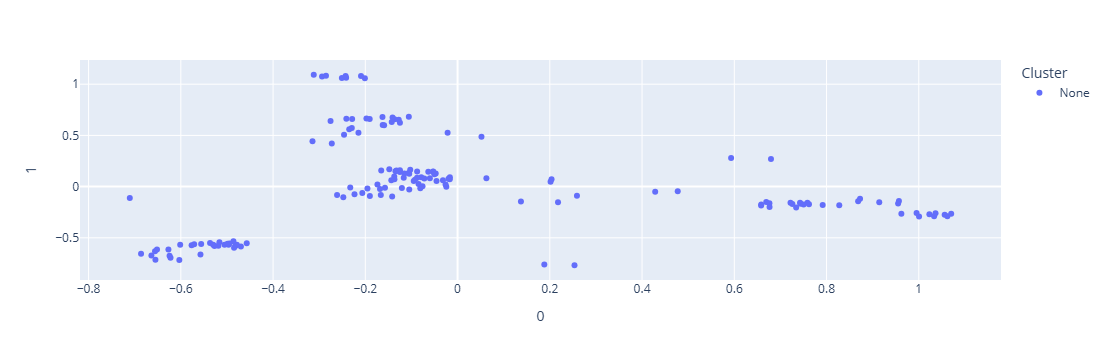

In [339]:
# Your Code
plot_pca_data(pca_scaled_pokemon)

## 3. Clustering mit dem KMeans Algorithmus

Im letzten Teil des Versuchs wenden wir nun endlich ein Clustering Verfahren an. Wie ihr sehen werded, ist dies sehr einfach und auch der Grund, warum sich die ganze Vorarbeit auszahlt :)

**Aufgabe 10:**

1. Implementiert eine Funktion `kmeans(dataframe, n_cluster)`, die ein noch nicht reduzierten Dataframe, sowie die Anzahl der gewünschten Cluster akzeptiert. Als Rückgabewert erstellen wir ein Cluster Dictionary, das wir dann in der `compare_cluster`-Methode zur Analyse und Interpretation der Cluster verwenden können.
2. Instanziiert ein [`from sklearn.cluster import KMeans` (link)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) Objekt mit `n_cluster`.
3. Wendet die Methode `apply_pca` auf den Dataframe an und fittet den KMeans-Algorithmus auf die transformierten Daten.
4. Ruft die Methode `plot_pca_data` auf und übergebt zusätzlich die Liste der gefundenen Cluster Labels. Optional kann zusätzlich noch die Liste der Clusterzentren übergeben werden.
5. Als letzten Schritt konvertieren wir noch die Liste der Cluster Labels in ein Cluster Dictionary. Implementiert diesen Schritt zunächst in einer separaten Code Zelle und integriert diesen dann in die `kmeans`-Methode, wenn ihr euch sicher seid, dass alles funktioniert.
6. Schaut euch zunächst die Liste an Cluster Labels an, die der KMeans-Algorithmus erzeugt. Diese möchten wir in ein Dictionary mit dem selben Format wie die Fake Cluster bringen. Die Keys sollen dabei die Cluster IDs sein, die Values jeweils eine Liste mit den Indizes der Elemente, die diesem Cluster zugeordnet wurden. Mit der Methode `np.unique` könnt ihr überprüfen welche eindeutigen Cluster IDs es gibt. Iteriert dann über diese Liste an IDs und verwendet `np.where`, um zu sehen welche Elemente in der Label Liste diesem Cluster zugeordnet wurden (ihr bekommt jeweils eine Liste mit den Indizes der Elemente zurück). Baut damit ein Cluster Dictionary und gebt dieses als Rückgabewert aus.

In [348]:
# Your Code
def kmeans(dataframe, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto')
    transformed_df = apply_pca(dataframe)
    kmeans.fit(transformed_df)
    plot_pca_data(transformed_df, kmeans.labels_, kmeans.cluster_centers_)

    cluster_Ids = np.unique(kmeans.labels_)
    cluster_dict = {}
    for value in cluster_Ids:
        cluster_dict[value] = np.where(kmeans.labels_ == value)
    return cluster_dict

7. Zeigt beispielhaft das Ergebnis eines Clusterings und dass `compare_cluster` korrekt mit eurem Cluster Dictionary umgehen kann.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



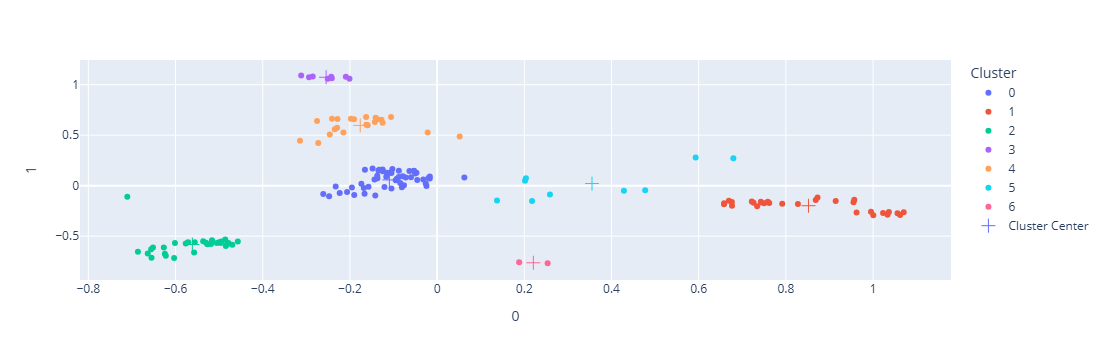

In [349]:
# Test Cell
cluster = kmeans(scaled_df_pokemon, 7)

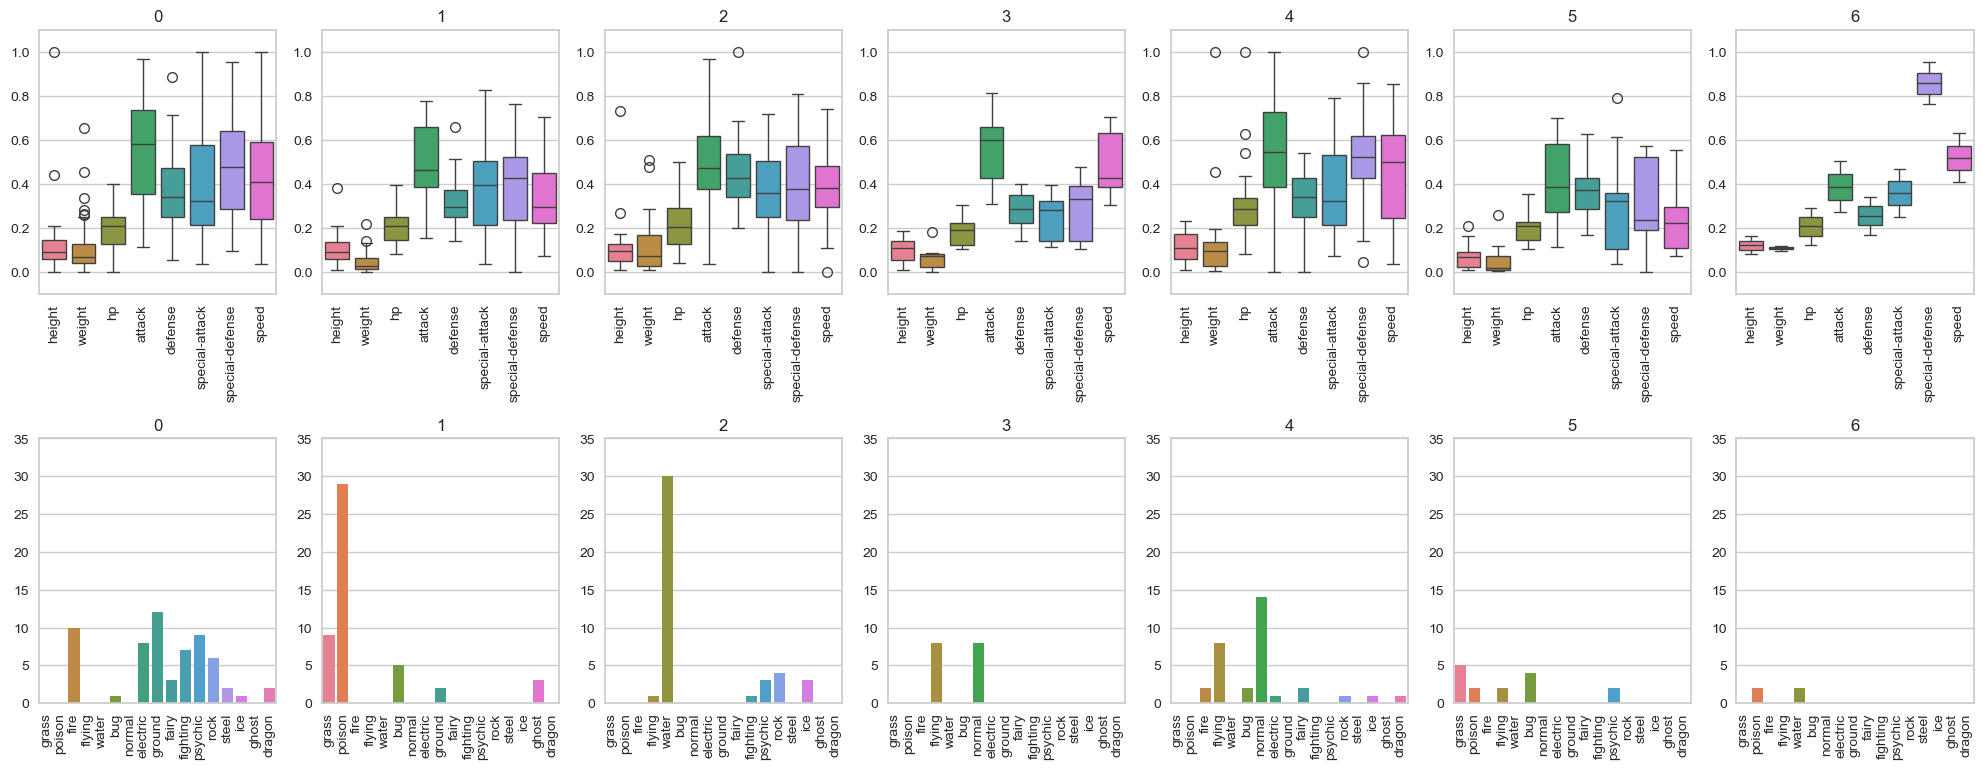

Cluster: 0


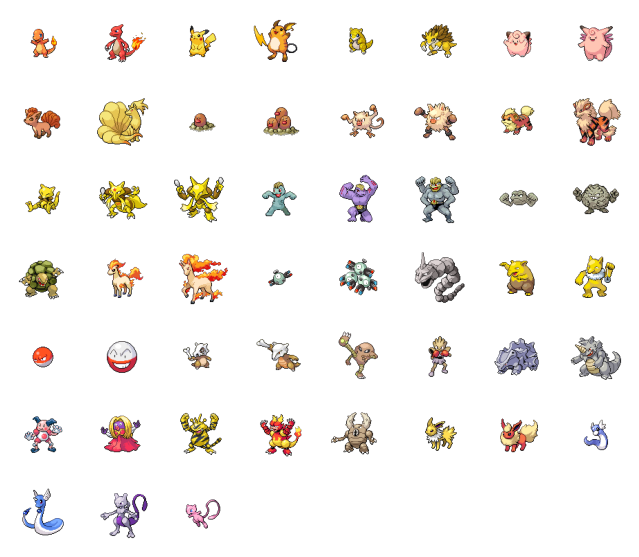

Cluster: 1


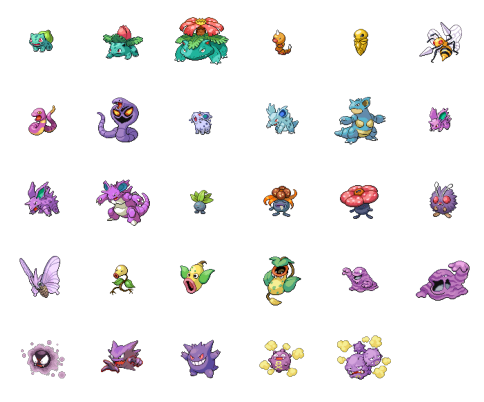

Cluster: 2


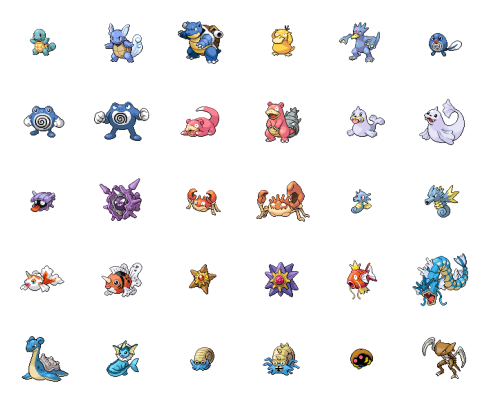

Cluster: 3


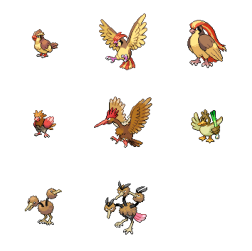

Cluster: 4


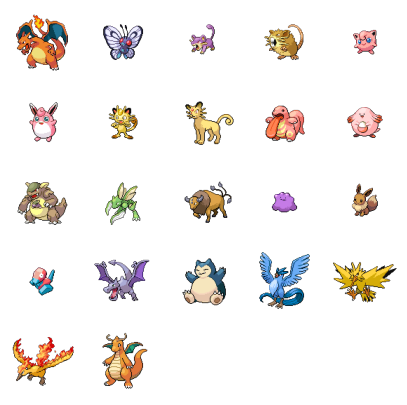

Cluster: 5


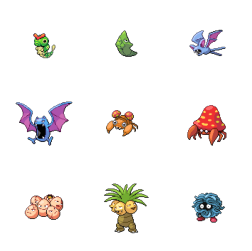

Cluster: 6


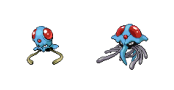

In [362]:
compare_cluster(cluster, scaled_df_pokemon, pictures)

**Aufgabe 11**:

1. Visualisiert euch die PCA für **numerische und kategorische Werte**. Wie viele Cluster erwartet ihr zu finden? 

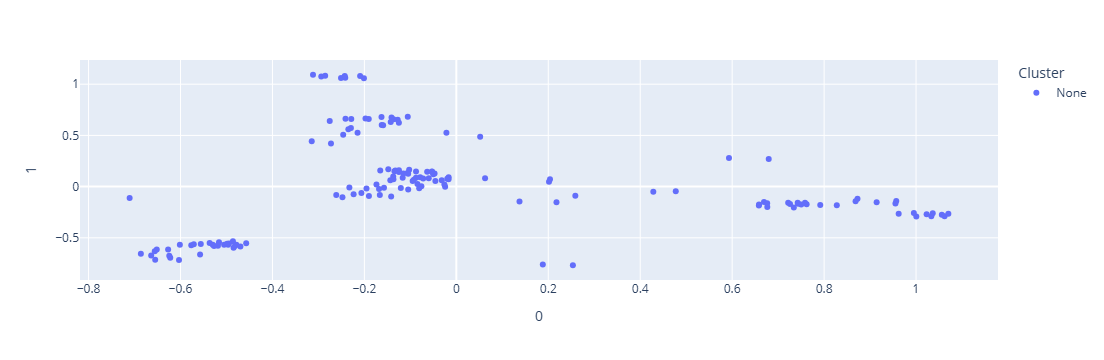

In [351]:
# Your Code
pca_scaled_numeric_categoric = apply_pca(scaled_df_pokemon)
pca_scaled_numeric_categoric

plot_pca_data(pca_scaled_numeric_categoric)
#wir erwarten sechs Cluster

2. Wendet den KMeans-Algorithmus mit dieser Anzahl auf die Daten an. Entspricht das Clustering euren Erwartungen?

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



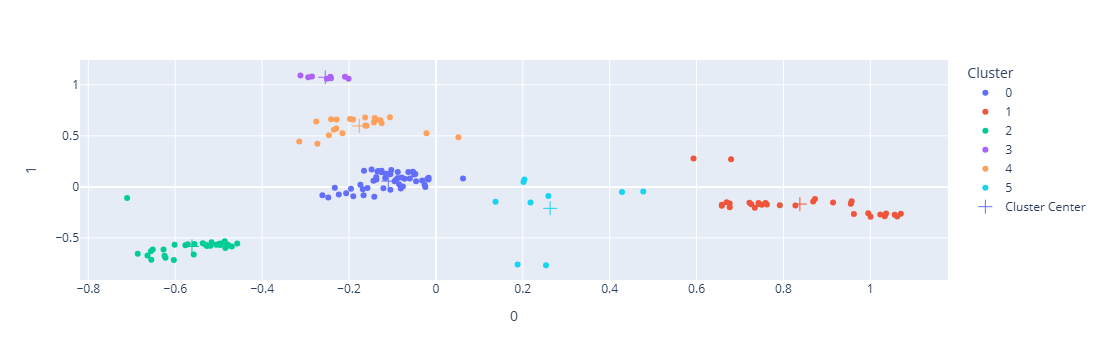

In [374]:
cluster_numeric_categoric = kmeans(pca_scaled_numeric_categoric, 6)
#Das Clustering sieht in etwa so aus wie wir es erwartet haben

3. Was ist für euch subjektiv gesehen eine optimale Anzahl an Clustern?

Es dürfen nicht zuviele Cöuster gebildet werden, damit nicht jeder Ausreißer ein eigenes Cluster ist. Allerdings sollten genug gebildet werden damit die Cluster noch kompakt genug sind. (nicht zuviel Leerraum in einen Cluster)

Unsere erwarteten 6 Cluster sehen schon sehr optimal aus.

4. Analysiert und diskutieren die gefundenen Cluster mit den implementierten Methoden. Welche Merkmale oder Arten von Merkmalen haben eurer Meinung nach den größten Einfluss auf das Clustering?

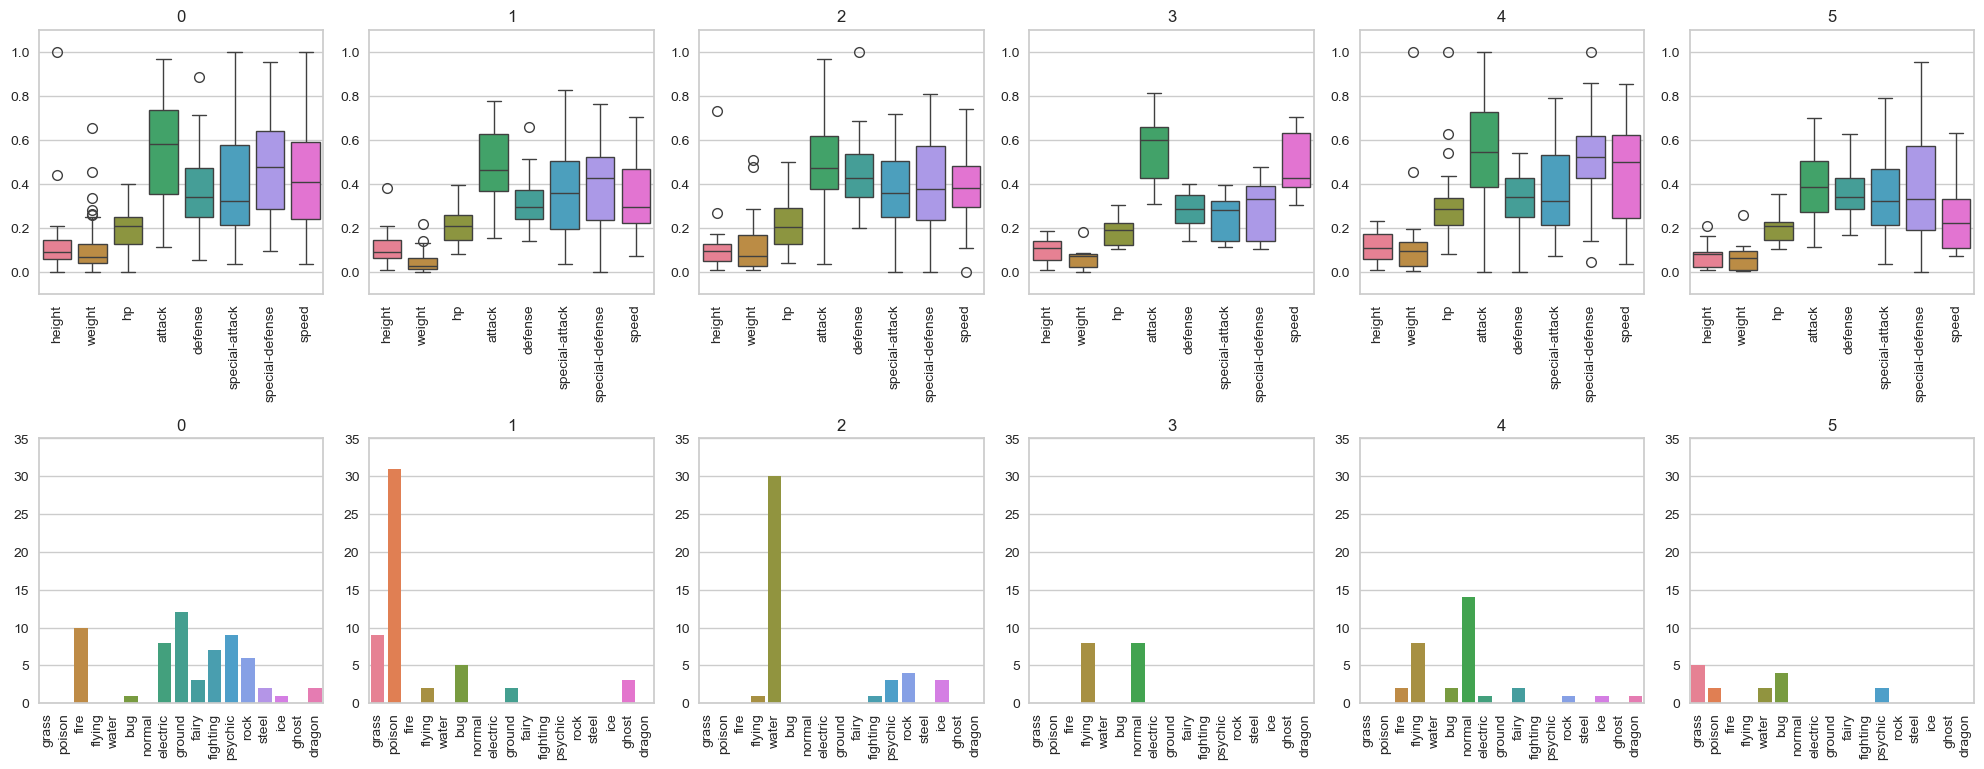

Cluster: 0


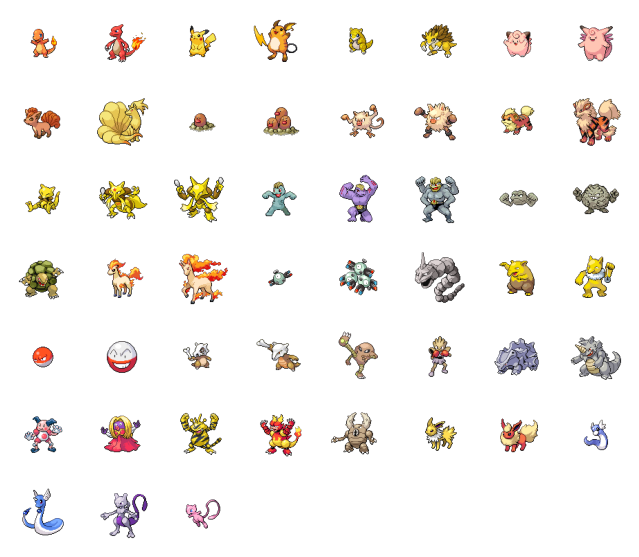

Cluster: 1


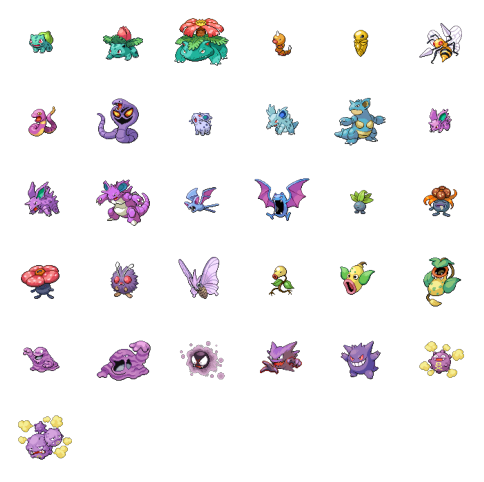

Cluster: 2


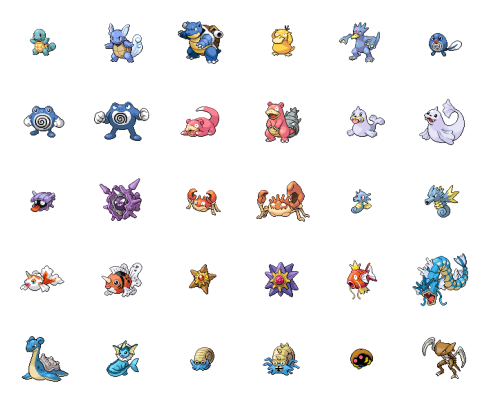

Cluster: 3


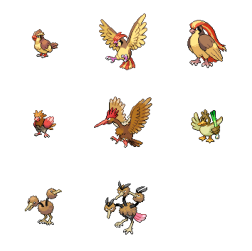

Cluster: 4


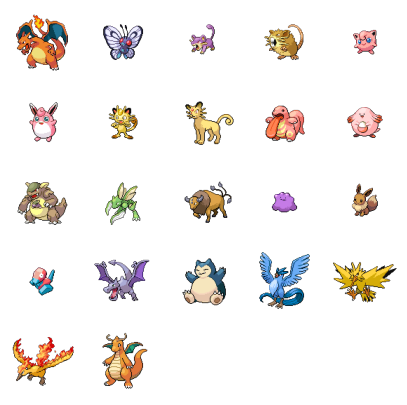

Cluster: 5


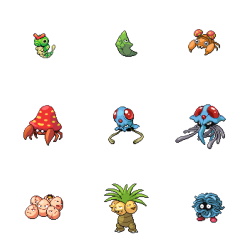

In [360]:
compare_cluster(cluster_numeric_categoric, scaled_df_pokemon, pictures)

* height, weight sind nicht relevant für die Clusterzuweisung
* Die Typen der Pokemon sind sehr aussagekräftig (Cluster1 ist quasi nur Gift, Cluster 2 ist nur Wasser, Cluster 3 ist nur fliegend und normal)
* wie bereits aus dem Pairplot erkannt wurde sind attack, defense, special-attack, special-defense sehr gleichmäßig verteilt und somit nicht sehr aussagekräftig

5. Optional: Beschreibt die gefundenen Cluster mit einer kurzen Zusammenfassung, z.B. "Cluster 1: Große blaue Dreiecke".

* Cluster 0: kleines liegendes blaues Oval
* Cluster 1: lange rote flache Linie (2 Ausreißer)
* Cluster 2: liegendes flaches grünes Oval (1 Ausreißer)
* Cluster 3: kurze flache lila Linie 
* Cluster 4: leicht gewölbte orangene Form
* Cluster 5: verteilte hellblaue Punkte (keine feste Form)
  

**Aufgabe 12**:

1. Visualisiert euch die PCA nur für **numerische Werte**. Wie viele Cluster erwartet ihr zu finden? 

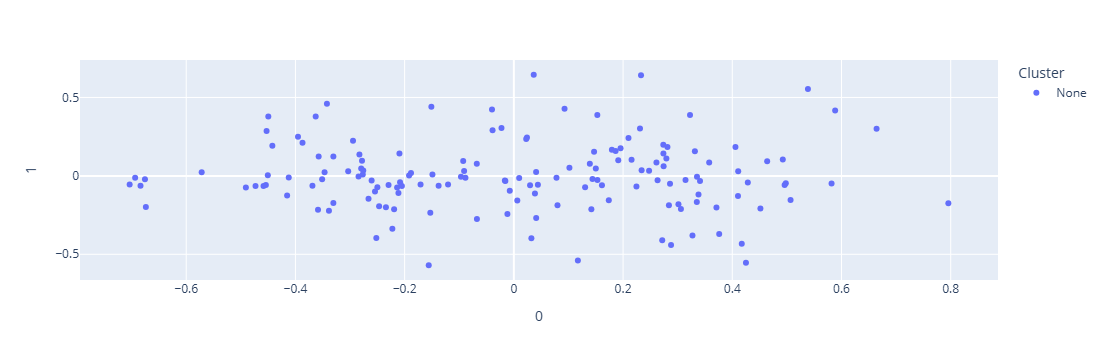

In [371]:
# Your Code
pca_scaled_numeric = apply_pca(scaled_df_pokemon.iloc[:,:8])

plot_pca_data(pca_scaled_numeric)
# schwer zu sagen sehr verteilt, maybe 3

2. Wendet den KMeans Algorithmus mit dieser Anzahl auf die Daten an. Entspricht das Clustering euren Erwartungen?

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



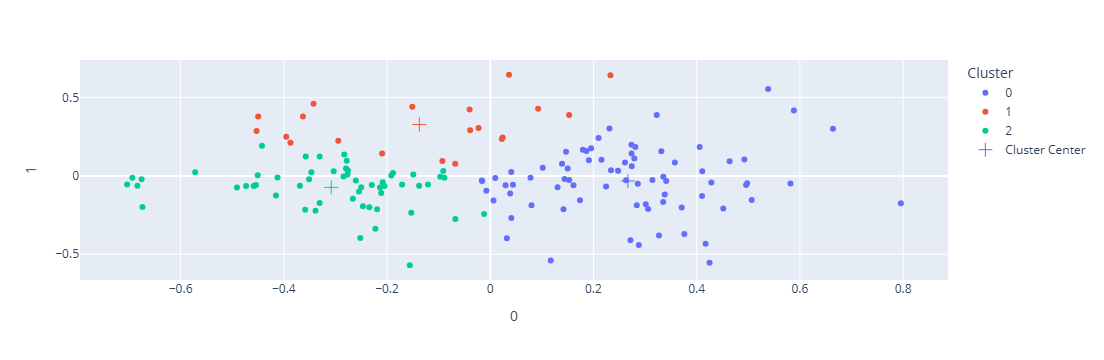

In [388]:
cluster_numeric = kmeans(pca_scaled_numeric, 3)
#sieht nich so aus wie wir es uns vorgestellt hatten

3. Was ist für euch subjektiv gesehen eine optimale Anzahl an Clustern?

Unsere gewählte 3 Cluster sehen nicht sehr optimal gewählt aus.

8 Cluster sehen für uns am besten aus.

4. Analysiert und diskutieren die gefundenen Cluster mit den implementierten Methoden. Welche Merkmale oder Arten von Merkmalen haben eurer Meinung nach den größten Einfluss auf das Clustering?

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



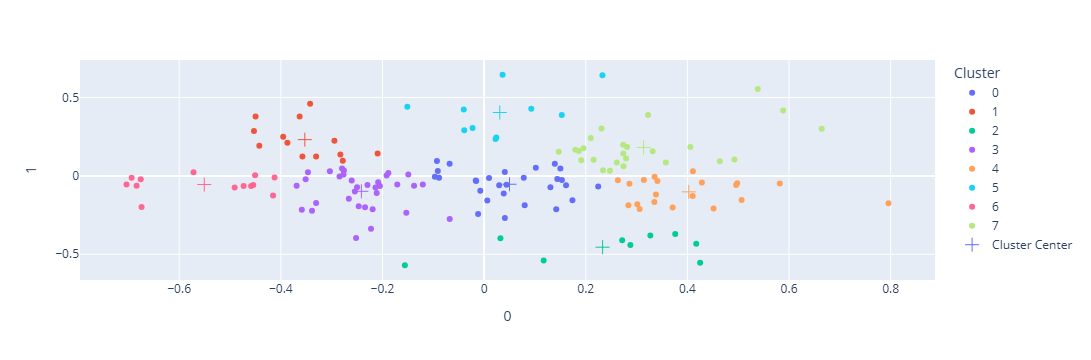

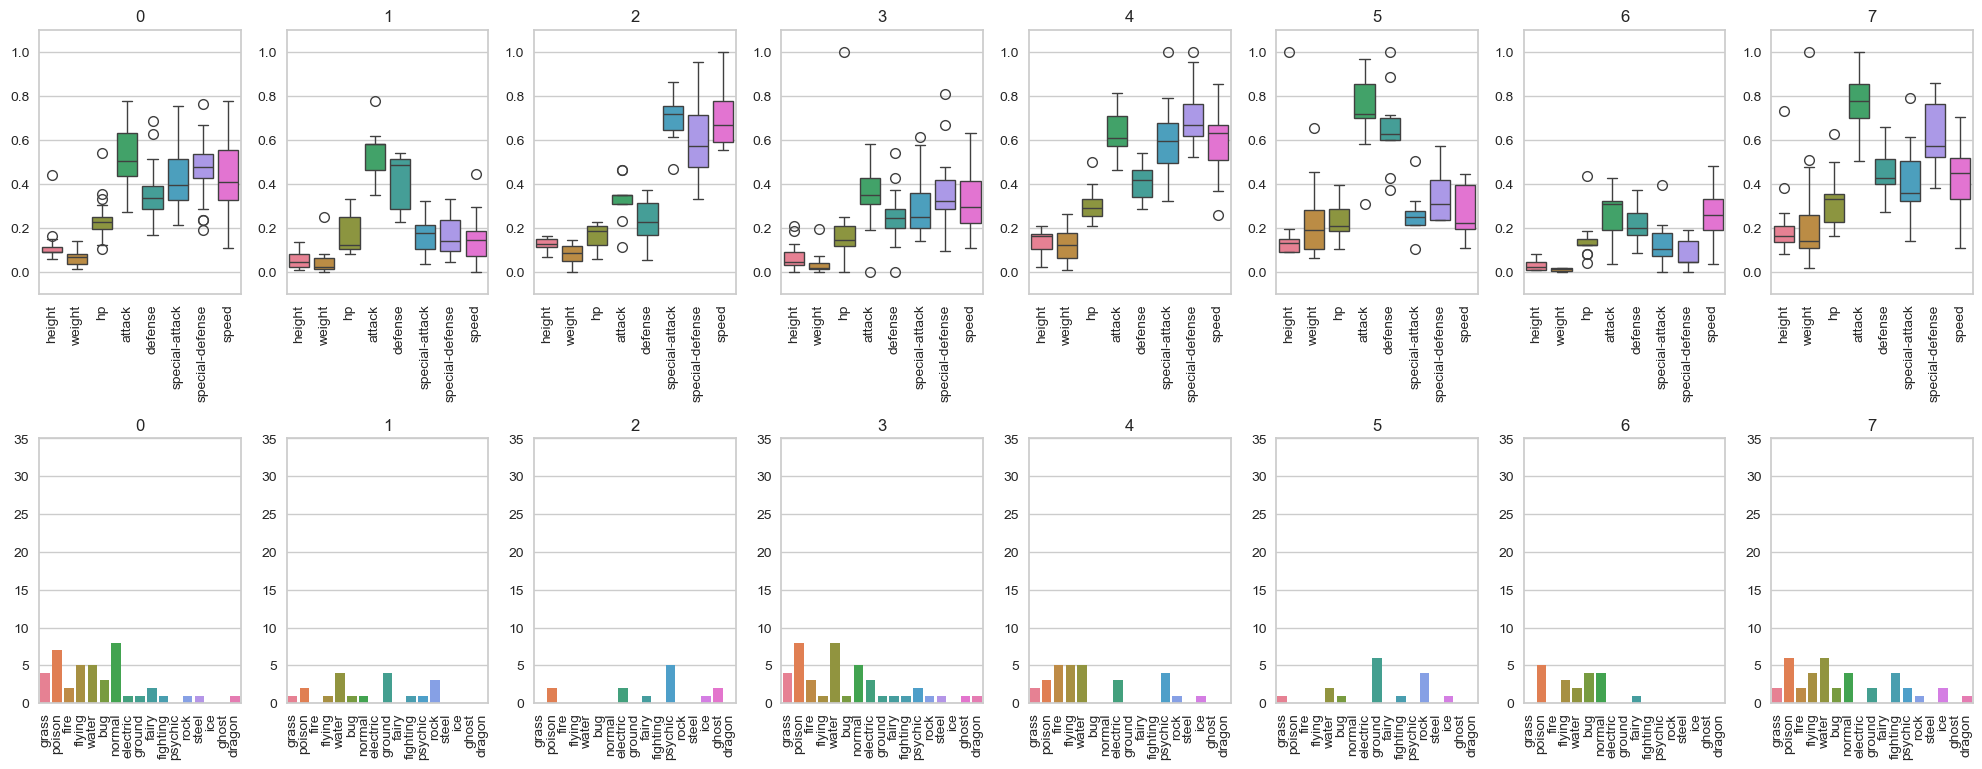

Cluster: 0


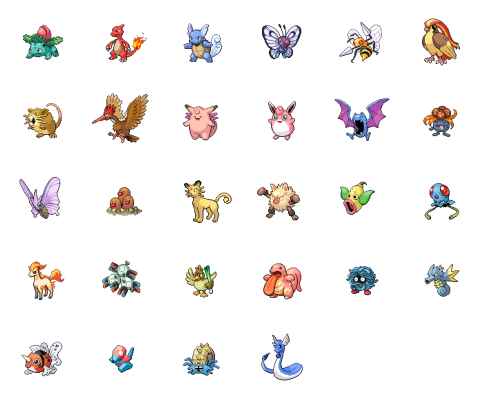

Cluster: 1


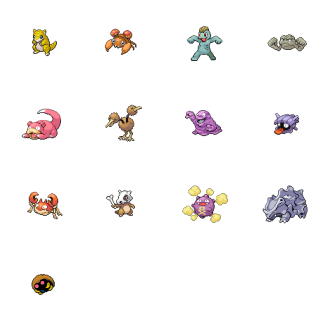

Cluster: 2


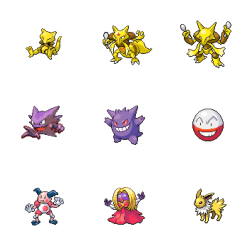

Cluster: 3


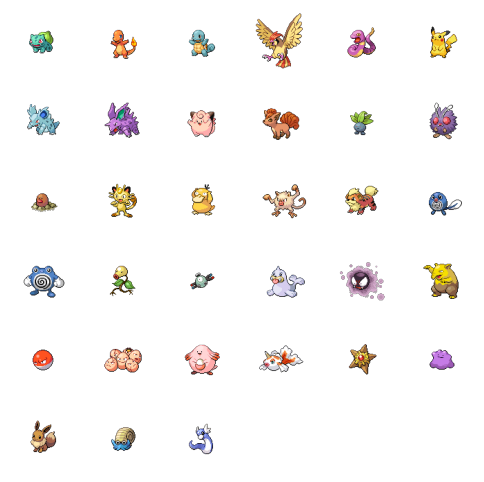

Cluster: 4


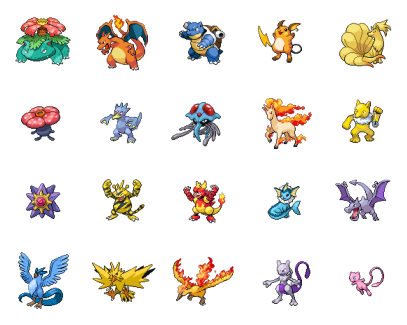

Cluster: 5


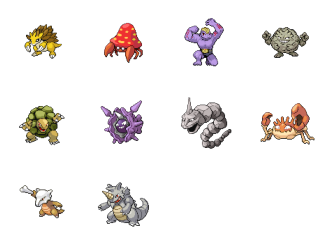

Cluster: 6


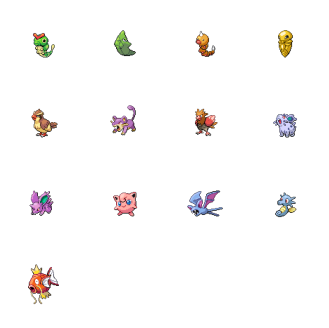

Cluster: 7


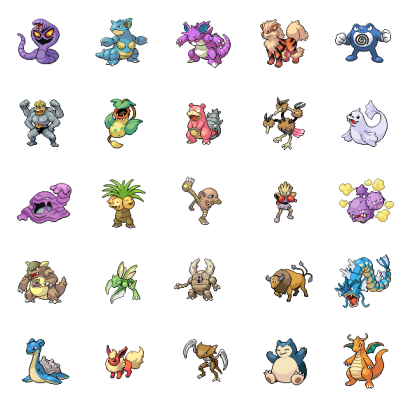

In [389]:
cluster_numeric = kmeans(pca_scaled_numeric, 8)
compare_cluster(cluster_numeric, scaled_df_pokemon, pictures)

* Die Verteilung bei nur numerischen Daten ist sehr gleichmäßig verstreut, wodurch sich keine eindeutigen Cluster bilden lassen.
* Manche Cluster unterscheiden sich durch große Unterschieden in ein paar Maerkmalen:
  * Cluster 1,6 special-attack, special-defense, speed eher niedrig
  * Cluster 2,4 special-attack, special-defense, speed eher höher
  * Cluster 2 ist deutlich niedriger in attack und defense
  * Cluster 6 sind sehr niedrig in height und weight
* es gibt kein dominates Merkmal, die verschiedenen Merkmale spielen je nach Cluster eine wichtigere oder unwichtigere Rolle im Clustering.

5. Vergleicht die Ergebnisse mit denen aus Versuch 10.

In Aufgabe 10 sind Cluster auf dem Plot grob zu erkennen. Dies ist hier(Aufgabe 12) nicht der Fall. Durch das Weglassen der Typen sind die Daten mehr und gleichmäßiger verstreut, wodurch es schwieriger wird einzelne Cluster zu erkennen.

Dadurch lässt sich zeigen, dass die Typen der Pokémons sehr wichtig für das Clustering sind.

6. Optional: Beschreibt die gefundenen Cluster mit einer kurzen Zusammenfassung, z.B. "Cluster 1: Kleine rote Kreise".

* Cluster 0: Blaues noch relativ kompaktes Parallelogram
* Cluster 1: Roter noch kompakter Kreis
* Cluster 2: Dunkelgrüne sehr stark zerstreute Linie
* Cluster 3: Lila noch kompaktes Rechteck
* Cluster 4: Orangenes relative kompaktes Oval
* Cluster 5: Hellblaues sehr zerstreutes Dreieck
* Cluster 6: Pinke gestreckte Linie
* Cluster 7: Hellgrüne relative kompaktes Viereck


**Aufgabe 13:**

1. Berechnet für die gefundenen Cluster aus Aufgabe 11 und/oder 12 die [Elbow Methode](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) und den [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a m

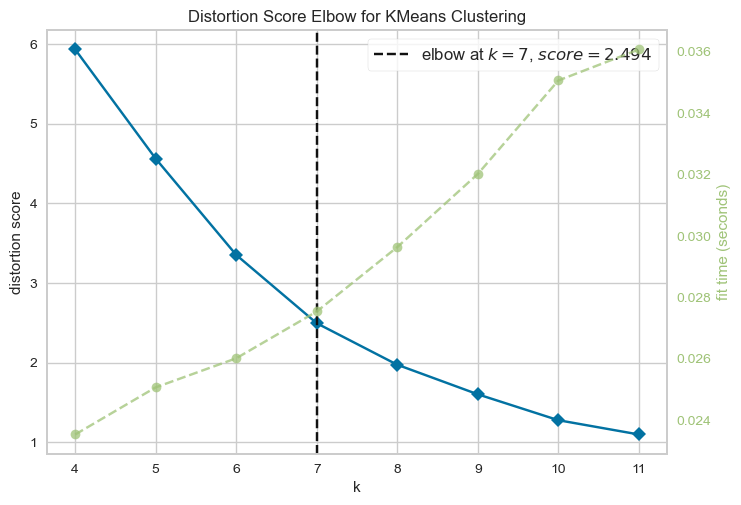

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [392]:
#11 Elbow Methode
model_n_c = KMeans(random_state=42, n_init=10)
visualizer_n_c = KElbowVisualizer(model_n_c, k=(4,12))
visualizer_n_c.fit(pca_scaled_numeric_categoric)
visualizer_n_c.show()

In [395]:
#11 Silhouette Score
kmeans_n_c = KMeans(n_clusters=7, random_state=42, n_init=10)
print(silhouette_score(pca_scaled_numeric_categoric, kmeans_n_c.fit_predict(pca_scaled_numeric_categoric)))

0.7147916474269979


D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a m

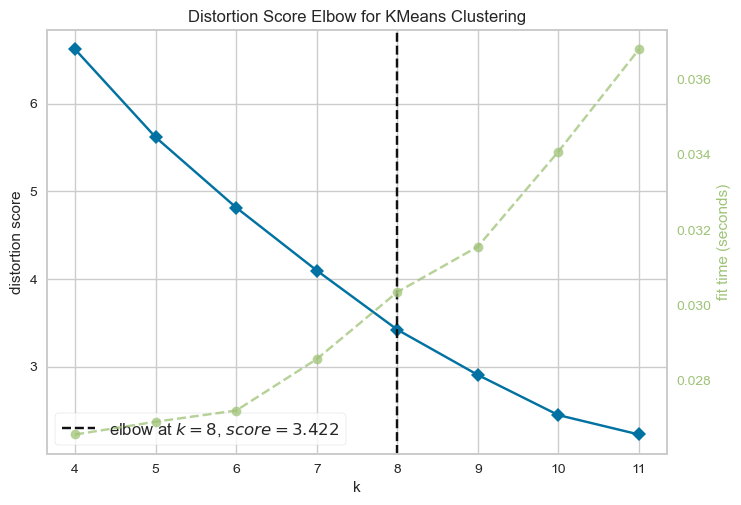

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [396]:
#12 Elbow Methode
model_n = KMeans(random_state=42, n_init=10)
visualizer_n = KElbowVisualizer(model_n, k=(4,12))
visualizer_n.fit(pca_scaled_numeric)
visualizer_n.show()

In [397]:
#12 Silhouette Score
kmeans_n = KMeans(n_clusters=8, random_state=42, n_init=10)
print(silhouette_score(pca_scaled_numeric, kmeans_n.fit_predict(pca_scaled_numeric)))

0.3700580114007494


D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



2. Was genau berechnet die Elbow Methode und der Silhouette Score?

Elbow: Berechnet die Optimale Cluster Anzahl durch Ausprobieren. Sie analysiert den Zusammenhang zwischen der Anzahl der Cluster und der Summe der quadrierten Abweichungen innerhalb der Cluster im Verhältnis zur Fiting Time. Die optimale Cluster Anzahl ist dann dort wo die beiden Werte am nächsten sind.

Silhoutte Score: Bewertet wie gut die einzelnen Datenpunkt zu ihrem Cluster passen und wwie gut sie von anderen Cluster getrennt sind. Der Silhoutte Score liegt dabei zwischen -1 und 1 wobei -1 das schlechteste Clusstering ist und 1 das optimale Clustering. Werte nahe der 0 deuten auf überlappende Cluster (siehe Clustering Aufgabe 12)

3. Passen die Scores zu eurer bisherigen Interpretation?

Ja, durch die Information der Typen beim Clustering, mit 6 Clustern ist der Silhoutte Score deutlich höher als ohne Typen.
Dies spiegelt sich auch in der Visualisierung der Cluster wieder. 

Bei Aufgabe 11 konnte bereits durch anschauen des Clusterings eine fast optimale Clusteranzahl gefunden werden (wir: 6, Elbow Methode: 7)

Bei Aufgabe 12 waren wir deutlich von der optimalen Clusteranzahl entfernt (wir: 3, Elbow Methode: 8)

**Aufgabe 13: (Verständnisfragen)**

1. Was ist die maximale Anzahl an möglichen Clustern, wenn die numerischen Werte Teil des Dataframes sind?

Max. Anzahl: 151 , da es 151 unteschiedliche Datenpunkte gibt

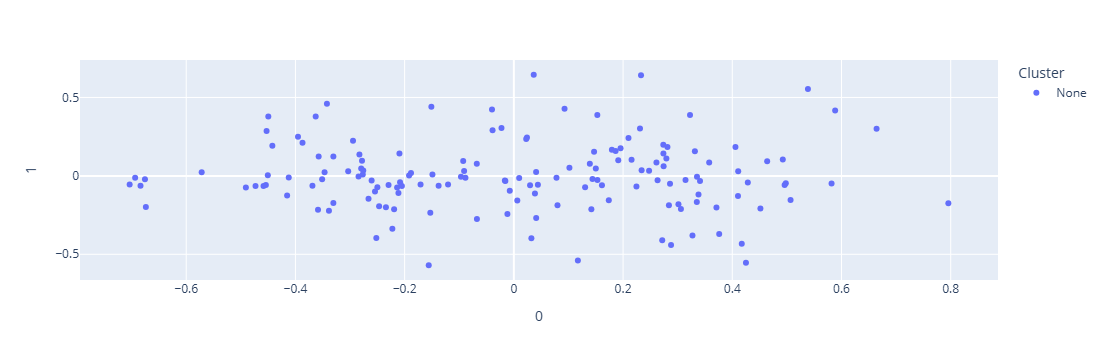

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



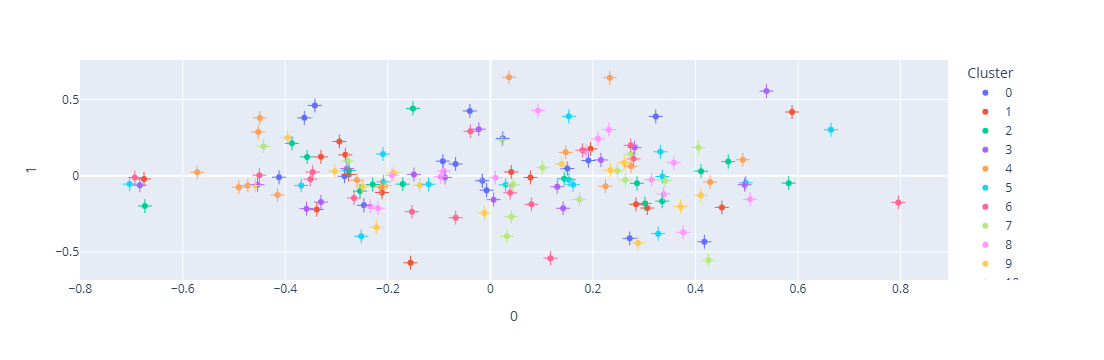

In [420]:
pca_scaled_numeric = apply_pca(scaled_df_pokemon.iloc[:,:8])
plot_pca_data(pca_scaled_numeric)
cluster_numeric = kmeans(pca_scaled_numeric, 151)

2. Was ist die maximale Anzahl an möglichen Clustern, wenn nur die kategorischen Daten verwendet würden?

Max. Anzahl: 37, da es nur 37 unterschiedliche typkombination in dem Datensatz gibt (ermittelt durch Fehlermeldungen)

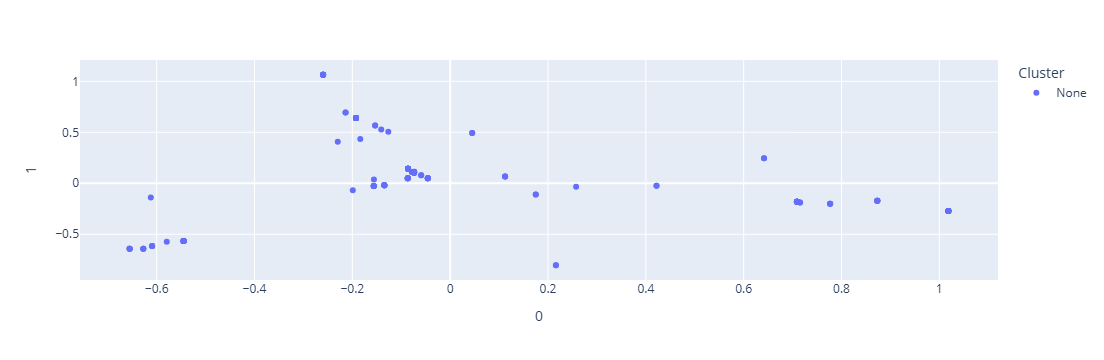

D:\Programme\anaconda3\envs\firsttestenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



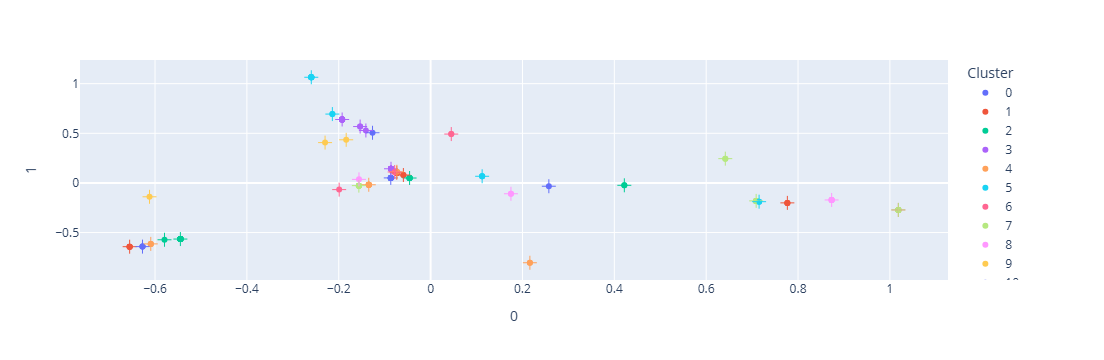

In [416]:
pca_scaled_categoric = apply_pca(scaled_df_pokemon.iloc[:,8:])
plot_pca_data(pca_scaled_categoric)
max_cluster_count = len(np.unique(pca_scaled_categoric))
cluster_numeric = kmeans(pca_scaled_categoric, 37)

3. Wie beurteilt ihr die Verwendung von kategorischen Merkmalen im Clustering? Konnten dadurch Cluster gefunden werden, die ihr ohne die Hilfe des Algorithmus nicht so einfach gefunden hättet?

Durch die Verwendung der katigorischen Merkmalen kann man eindeutiger die Datenpunkte Clustern zuweisen.

Wie in Aufgabe 12 zu erkennen ist, sind die Datenpunkte ohne die kategorischen Merkmale gleichmäßig Verteilt. In Aufgabe 11 bilden sich durch das Hinzufügen der kategorischen Merkmalen, mit dem blosen Auge zu erkennende Cluster.

Nur numerische Merkmale (Aufgabe 12)


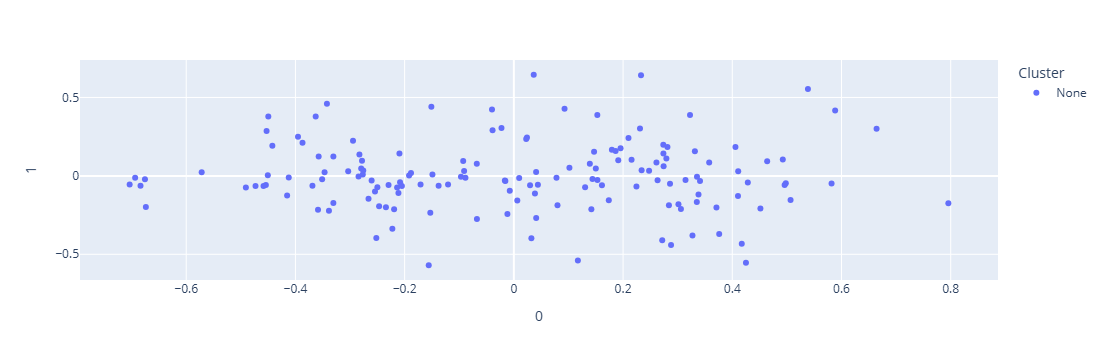

Mit kategorischen Merkmale (Aufgabe 11)


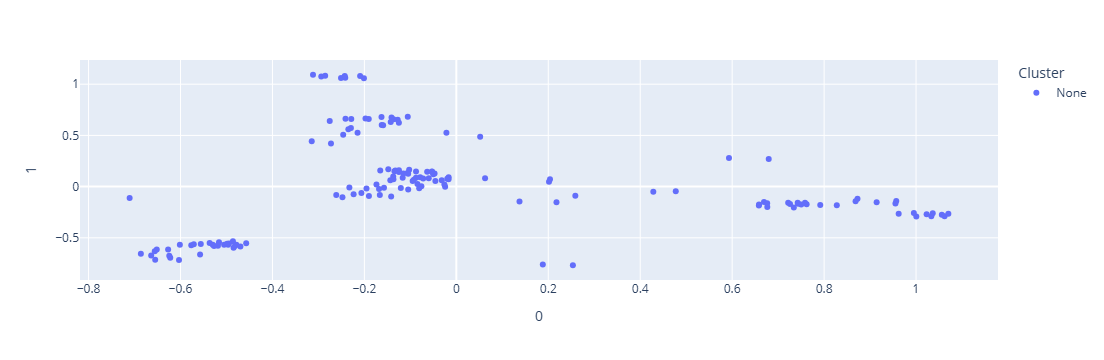

In [422]:
print("Nur numerische Merkmale (Aufgabe 12)")
plot_pca_data(pca_scaled_numeric)
print("Mit kategorischen Merkmale (Aufgabe 11)")
plot_pca_data(pca_scaled_numeric_categoric)

4. Wie beurteilen Sie die Verwendung von numerischen Merkmalen im Clustering? Konnten dadurch Cluster gefunden werden, die ihr ohne die Hilfe des Algorithmus nicht so einfach gefunden hättet?

Begründet eure Antworten entweder theoretisch (nur Text) und/oder optional auch empirisch (mit Code).

Das verwenden von numerischen Merkmalen hat einen geringen Einfluss auf das Clustering des Datensatzes.
Wie auf den folgenden Plots zu erkennen ist, können durch rein kategorische Merkmale Cluster erkannt werden. Das Hinzufügen der numerischen Merkmale liefert eine leicht Streuung der einzelne Cluster, ändert das Clustering an sich allerdings wenig.

Nur kategorischen Merkmale


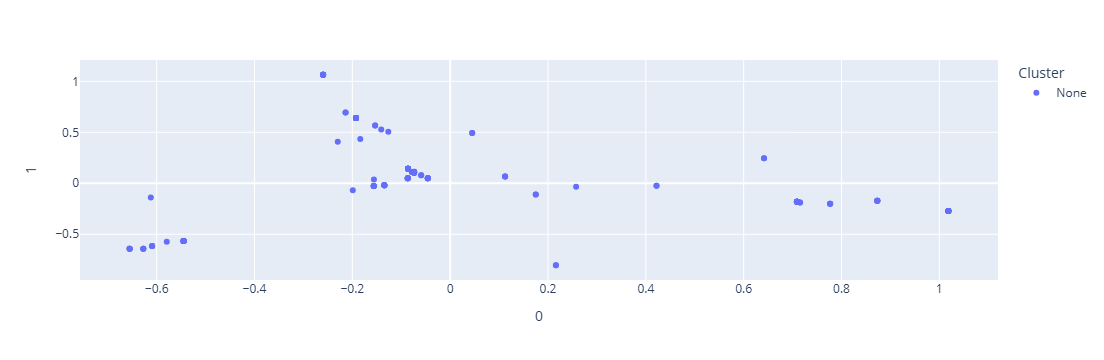

Mit numerischen Merkmale (Aufgabe 11)


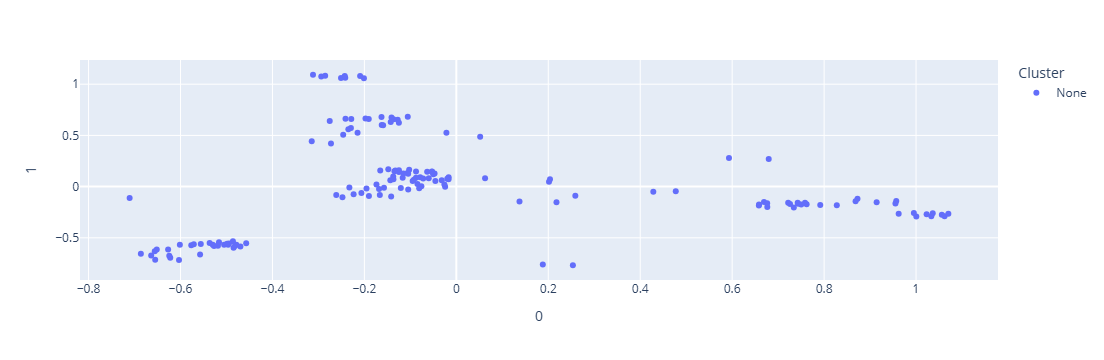

In [424]:
print("Nur kategorischen Merkmale")
plot_pca_data(pca_scaled_categoric)
print("Mit numerischen Merkmale (Aufgabe 11)")
plot_pca_data(pca_scaled_numeric_categoric)